In [1]:
import pennylane as qml
from pennylane import numpy as qnp
import itertools
import numpy as onp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
class explore(object):
    def __init__(self,name,algorithm):
        self.data = np.loadtxt(f"{name}", delimiter=",")
        self.algorithm = algorithm
        valid_Rs = [qml.RX, qml.RY, qml.RZ]
        if self.algorithm == "qa":
            valid_CNOTs = ([0, 3], [0, 4], [0, 5], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5])
        elif self.algorithm == "vqc":
            valid_CNOTs = []
            for i in range(6):
                for j in range(i+1,6):
                    valid_CNOTs.append([i,j])
        self.Rs_space = list(itertools.product(valid_Rs, valid_Rs, valid_Rs, valid_Rs, valid_Rs, valid_Rs))
        self.CNOTs_space = [[y for y in CNOTs if y is not None] for CNOTs in list(itertools.product(*([x, None] for x in valid_CNOTs)))]
        self.NAS_search_space = list(itertools.product(self.Rs_space, self.CNOTs_space))

    def model_fn_vqc(self,NAS1,NAS2,NAS3):
#        for i in range(3):
        circuit = [self.NAS_search_space[NAS1],self.NAS_search_space[NAS2],self.NAS_search_space[NAS3]]
        self.op_list = []
    #    wires = qml.wires.Wires(len(circuit[0]))
        weights = np.empty([len(circuit),len(circuit[0][0])])
        feature = np.empty(len(circuit[0][0]))
        for i in range(len(circuit[0][0])):
            self.op_list.append(qml.RX(feature[i], wires=i))
        for i in range(len(circuit)):
            for k in range(len(circuit[0][0])):
                self.op_list.append(circuit[i][0][k](weights[i, k], wires=k))
            for cnot in circuit[0][1]:
                self.op_list.append(qml.CNOT(wires=cnot))
        return self.op_list
    
    def model_fn_qa(self,Rs1,Rs2,Rs3,Cnot):
        circuit = [self.Rs_space[Rs1],self.Rs_space[Rs2],self.Rs_space[Rs3],self.CNOTs_space[Cnot]]
        self.op_list = []
    #    wires = qml.wires.Wires(len(circuit[0]))
        weights = np.empty([len(circuit)-1,len(circuit[0])])
        feature = np.empty(len(circuit[0]))
        for i in range(len(circuit[0])):
            self.op_list.append(qml.RX(feature[i], wires=i))
        for i in range(len(circuit)-1):
            for j in range(len(circuit[0])):
                self.op_list.append(circuit[i][j](weights[i, j], wires=j))
        for cnot in circuit[-1]:
            self.op_list.append(qml.CNOT(wires=cnot))
        return self.op_list
    
    def popularity_ranking(self,wires,Rs):
        auc = self.data[:,-1]
        Rs_shape = [len(Rs),len(Rs[0])]
        result = np.array([[np.NaN,np.NaN,np.NaN,np.NaN]])
        for i in range(Rs_shape[0]):
            for j in range(Rs_shape[1]):
                subnet_index = Rs[i][j]
                subnet = self.Rs_space[subnet_index]
                for k in range(wires):
                    gate = subnet[k]
                    if gate == qml.RX:
                        gate = 1
                    elif gate == qml.RY:
                        gate = 2
                    else:
                        gate = 3
                    if [j,k,gate] not in result[:,:-1].tolist():
                        result = np.append(result,
                                           [[j,k,gate,
                                             np.log(1 + (np.e-1) * (auc[i] - auc[-1]) / (auc[0] - auc[-1]))
                                             ]]
                                           ,axis=0)
                    else:
                        ind = result[:,:-1].tolist().index([j,k,gate])
                        result[ind,-1] += np.log(1 + (np.e-1) * (auc[i] - auc[-1]) / (auc[0] - auc[-1]))
        index = np.argsort(result[:,-1])
        self.result = result[index[::-1]][1:]
        self.result = np.hstack([np.arange(1,self.result.shape[0]+1,1).reshape(self.result.shape[0],1),self.result])
        return self.result
    
    def popularity_ranking_qa(self,wires):
        self.popularity_ranking(wires,self.data[:,:-1].astype(np.int))

    def popularity_ranking_vqc(self,wires):
        Rs = self.data[:,:-1].astype(np.int)//len(self.CNOTs_space)
        self.popularity_ranking(wires,Rs)
    
    def distribution_analysis(self,column,column_num,adjusted_cond=0):
        deepness_element = list(set(self.result[:,column]))
        l = np.full(len(deepness_element),np.NaN).reshape(len(deepness_element),1).tolist()
        for i in self.result[:,0]:
            ind = np.int(i)
            for j in range(column_num):
                if self.result[ind-1,column] == j+adjusted_cond:
                    l[j].append(self.result[ind-1,-1])
                    break
        for j in range(column_num):
            plt.figure()
            plt.xlabel("comprehensive performance")
            plt.ylabel("distribution")
            plt.hist(l[j],bins=50,label=f"{j+adjusted_cond}")
            plt.legend()

    def analysis_simplified(self,index):
        if index == 1:
            self.distribution_analysis(1,3,adjusted_cond=0)
        elif index == 2:
            self.distribution_analysis(2,6,adjusted_cond=0)
        else:
            self.distribution_analysis(3,3,adjusted_cond=1)

    def relationship_analysis(self,xindex,yindex):
        list1, list2 = self.result[:int(self.result.shape[0]/2),xindex].astype(np.int), self.result[:int(self.result.shape[0]/2),yindex].astype(np.int)
        list1_element = np.array(list(set(list1)))
        list2_element = np.array(list(set(list2)))
        self.rel = np.zeros([list1_element.shape[0],list2_element.shape[0]])
        if yindex==3:
            list2-=1
        elif xindex==3:
            list1-=1
        for i in range(list1.shape[0]):
            self.rel[list1[i],list2[i]] += 1
        self.xindex = xindex
        self.yindex = yindex

    def relationship_plot(self):
        # Flatten the 3D list and create lists for x, y, and sizes
        x_coords, y_coords = np.meshgrid(np.arange(self.rel.shape[0]),
                                        np.arange(self.rel.shape[1]))

        x = x_coords.flatten()
        y = y_coords.flatten()
        sizes = self.rel.flatten()

        # Create scatter plot
        plt.figure(figsize=(6,6))
        plt.scatter(x, y, s=100*sizes**2, c=sizes, cmap='coolwarm', marker='s', alpha=0.7)

        # Add color bar
        cbar = plt.colorbar()
        cbar.set_label('Value')

        if self.xindex == 1:
            plt.xlabel('deepness')
        elif self.xindex == 2:
            plt.xlabel('qubit')
        else:
            plt.xlabel('type of rotational gate')
        if self.yindex == 1:
            plt.ylabel('deepness')
        elif self.yindex == 2:
            plt.ylabel('qubit')
        else:
            plt.ylabel('type of rotational gate')

        plt.show()
            
    def draw_diagram(self):
        ind = self.data[:,:-1].astype(np.int)
        if self.algorithm == "qa":
            for i in range(ind.shape[0]):
                fig, ax = qml.draw_mpl(self.model_fn_qa, expansion_strategy="device"#, max_length=1000, style="pennylane"
                                    )(ind[i,0],ind[i,1],ind[i,2],ind[i,3])
        elif self.algorithm == "vqc":
            for i in range(ind.shape[0]):
                fig, ax = qml.draw_mpl(self.model_fn_vqc, expansion_strategy="device"#, max_length=1000, style="pennylane"
                                    )(ind[i,0],ind[i,1],ind[i,2])

In [57]:
c = explore("first_20th_vqc_train_bsm1_test_bsm1.csv","vqc")

/var/folders/t2/px5sbypn18d92blmdgj5yc_w0000gn/T/ipykernel_19872/1441363085.py:82: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rs = self.data[:,:-1].astype(np.int)//len(self.CNOTs_space)
/var/folders/t2/px5sbypn18d92blmdgj5yc_w0000gn/T/ipykernel_19872/1441363085.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

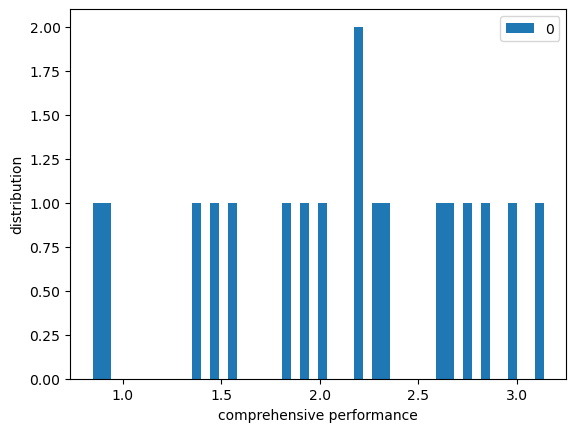

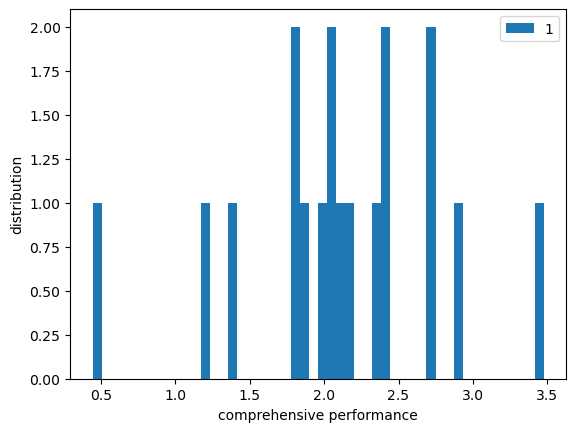

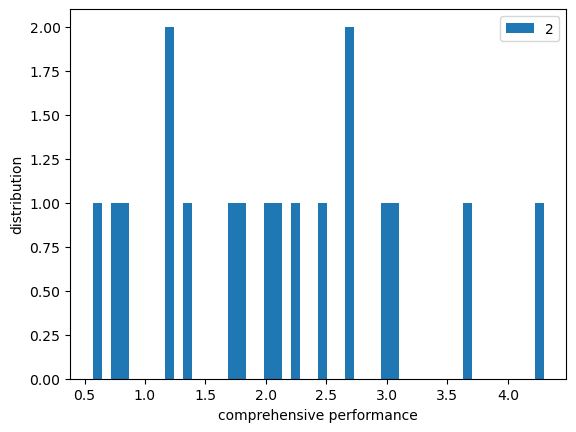

In [58]:
c.popularity_ranking_vqc(6)
c.analysis_simplified(1)

/var/folders/t2/px5sbypn18d92blmdgj5yc_w0000gn/T/ipykernel_19872/1441363085.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  list1, list2 = self.result[:int(self.result.shape[0]/2),xindex].astype(np.int), self.result[:int(self.result.shape[0]/2),yindex].astype(np.int)


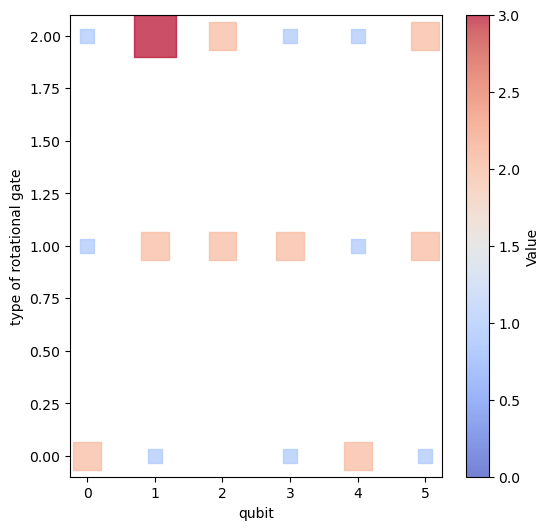

In [51]:
c.relationship_analysis(2,3)
c.relationship_plot()

/var/folders/t2/px5sbypn18d92blmdgj5yc_w0000gn/T/ipykernel_19872/1441363085.py:156: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind = self.data[:,:-1].astype(np.int)
/Users/hyrelfyseaq493/anaconda3/lib/python3.10/site-packages/pennylane/drawer/draw.py:536: UserWarning: When the input to qml.draw is not a QNode, the expansion_strategy argument is ignored.
  warnings.warn(
/Users/hyrelfyseaq493/anaconda3/lib/python3.10/site-packages/pennylane/drawer/draw.py:536: UserWarning: When the input to qml.draw is not a QNode, the expansion_strategy argume

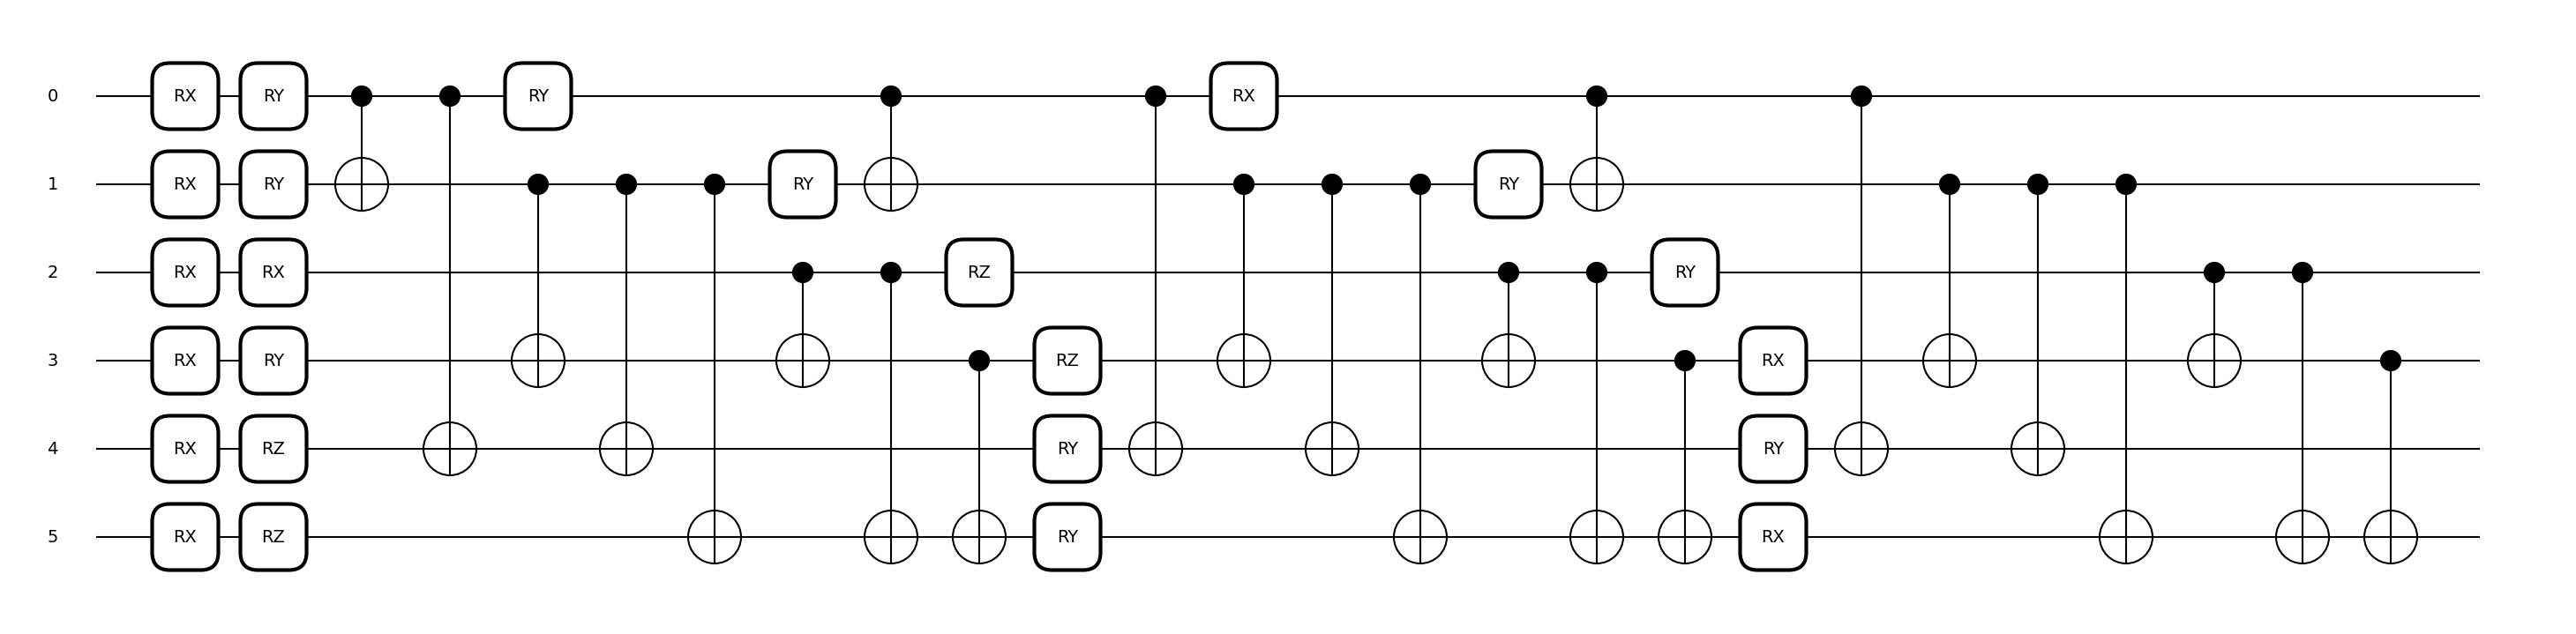

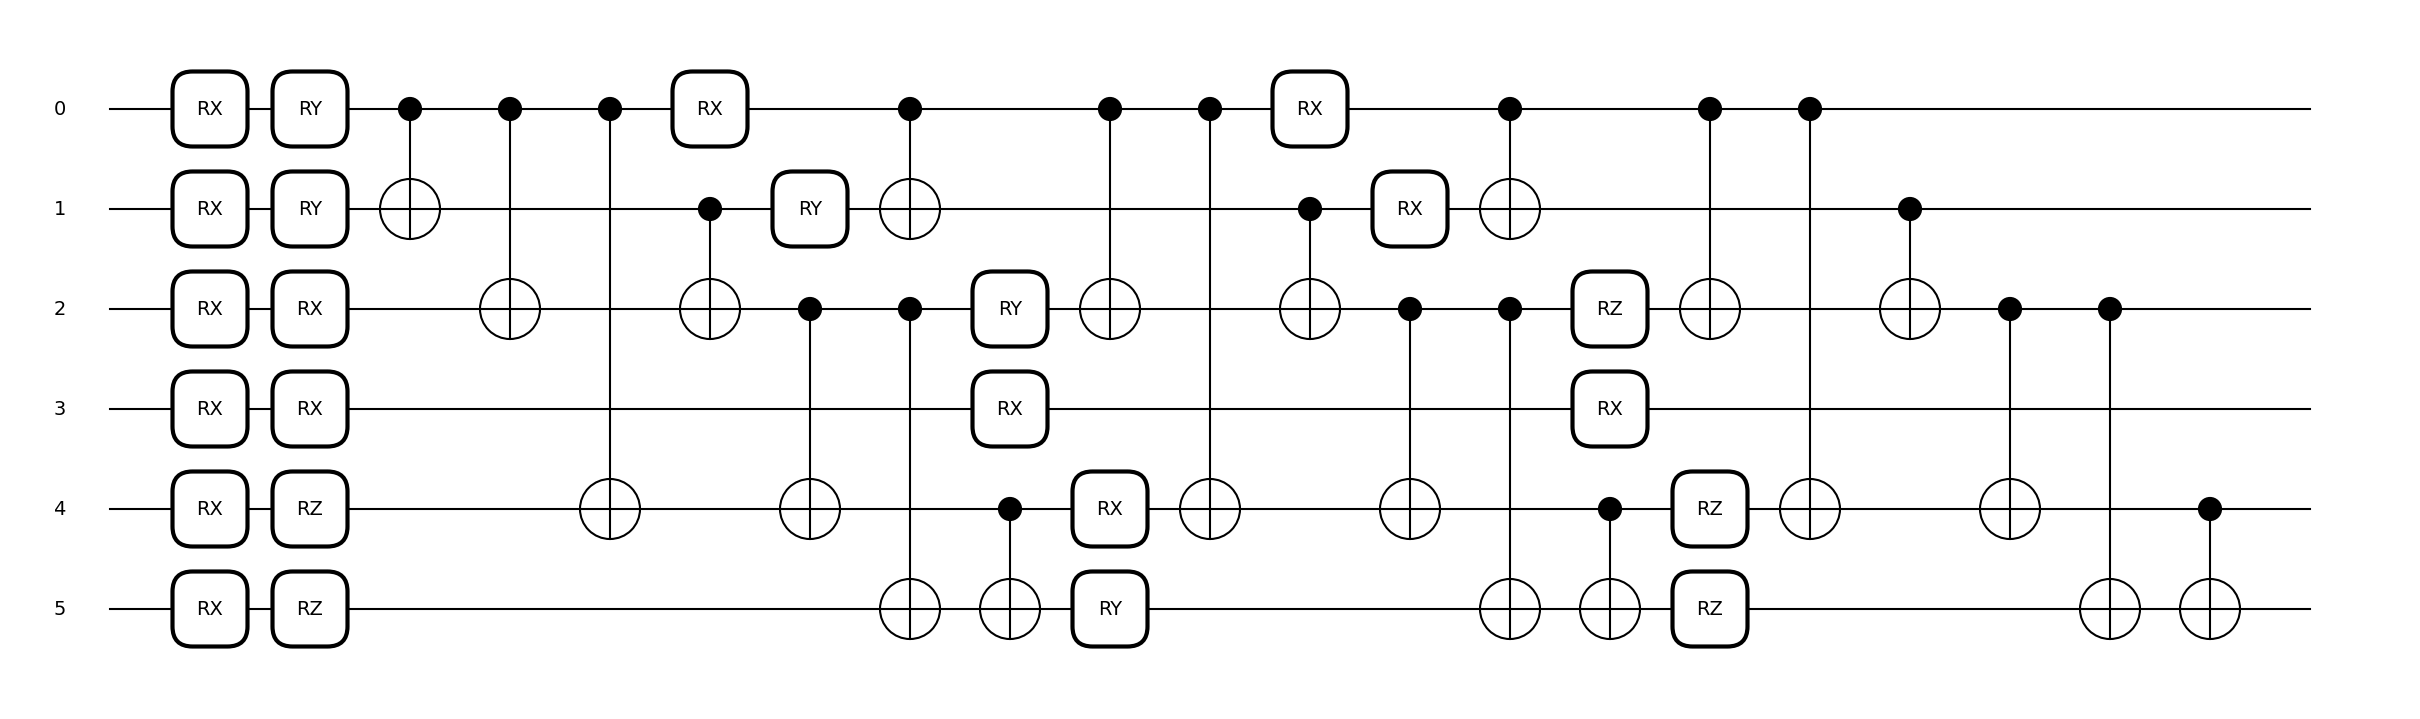

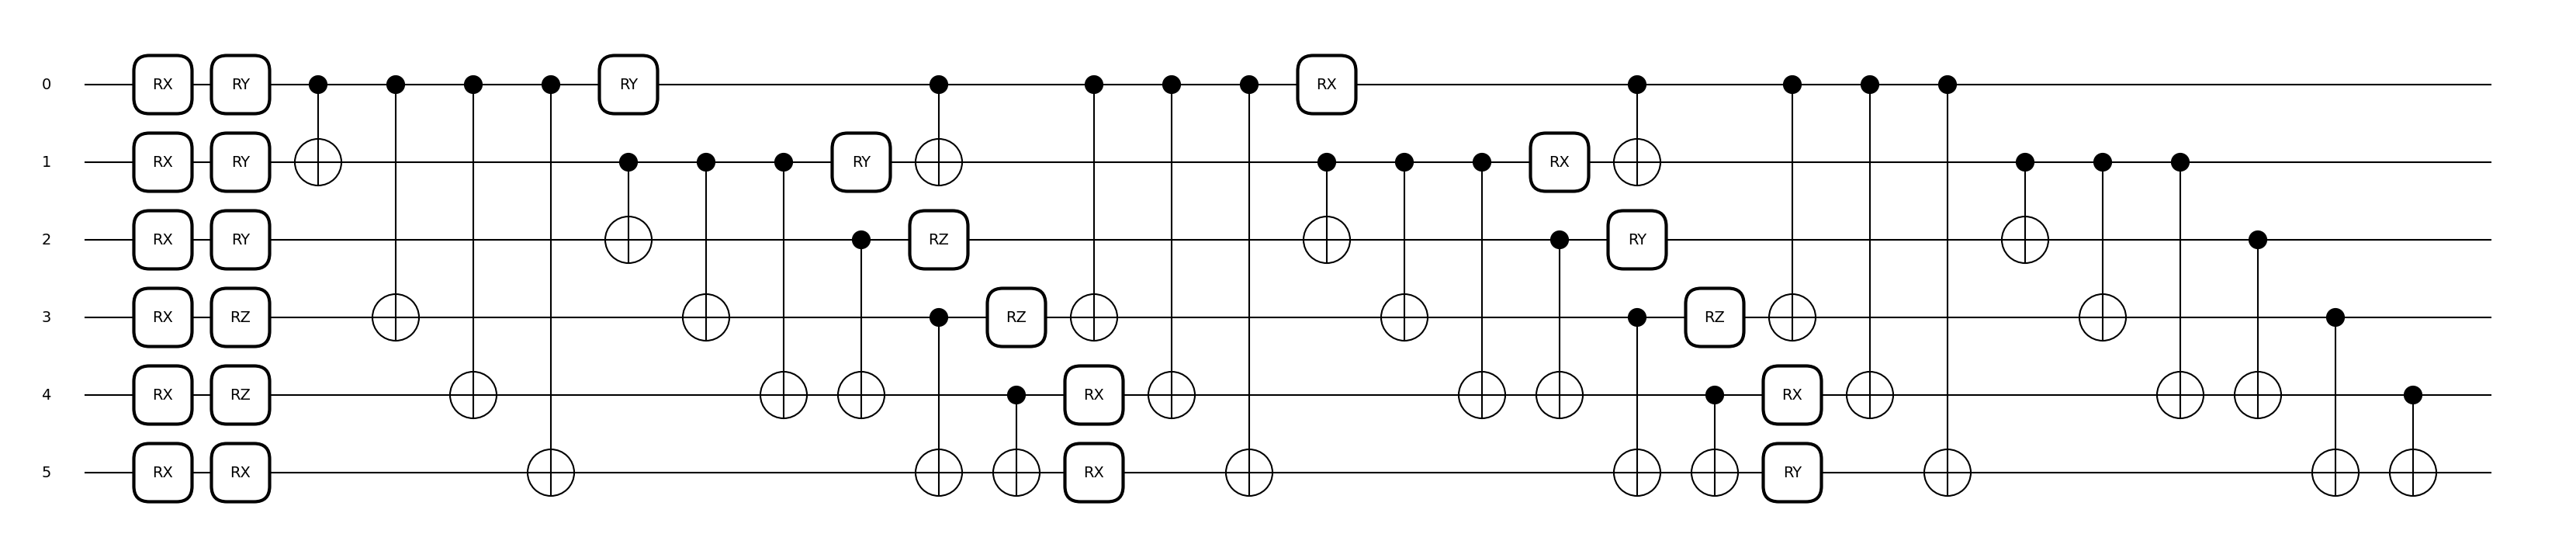

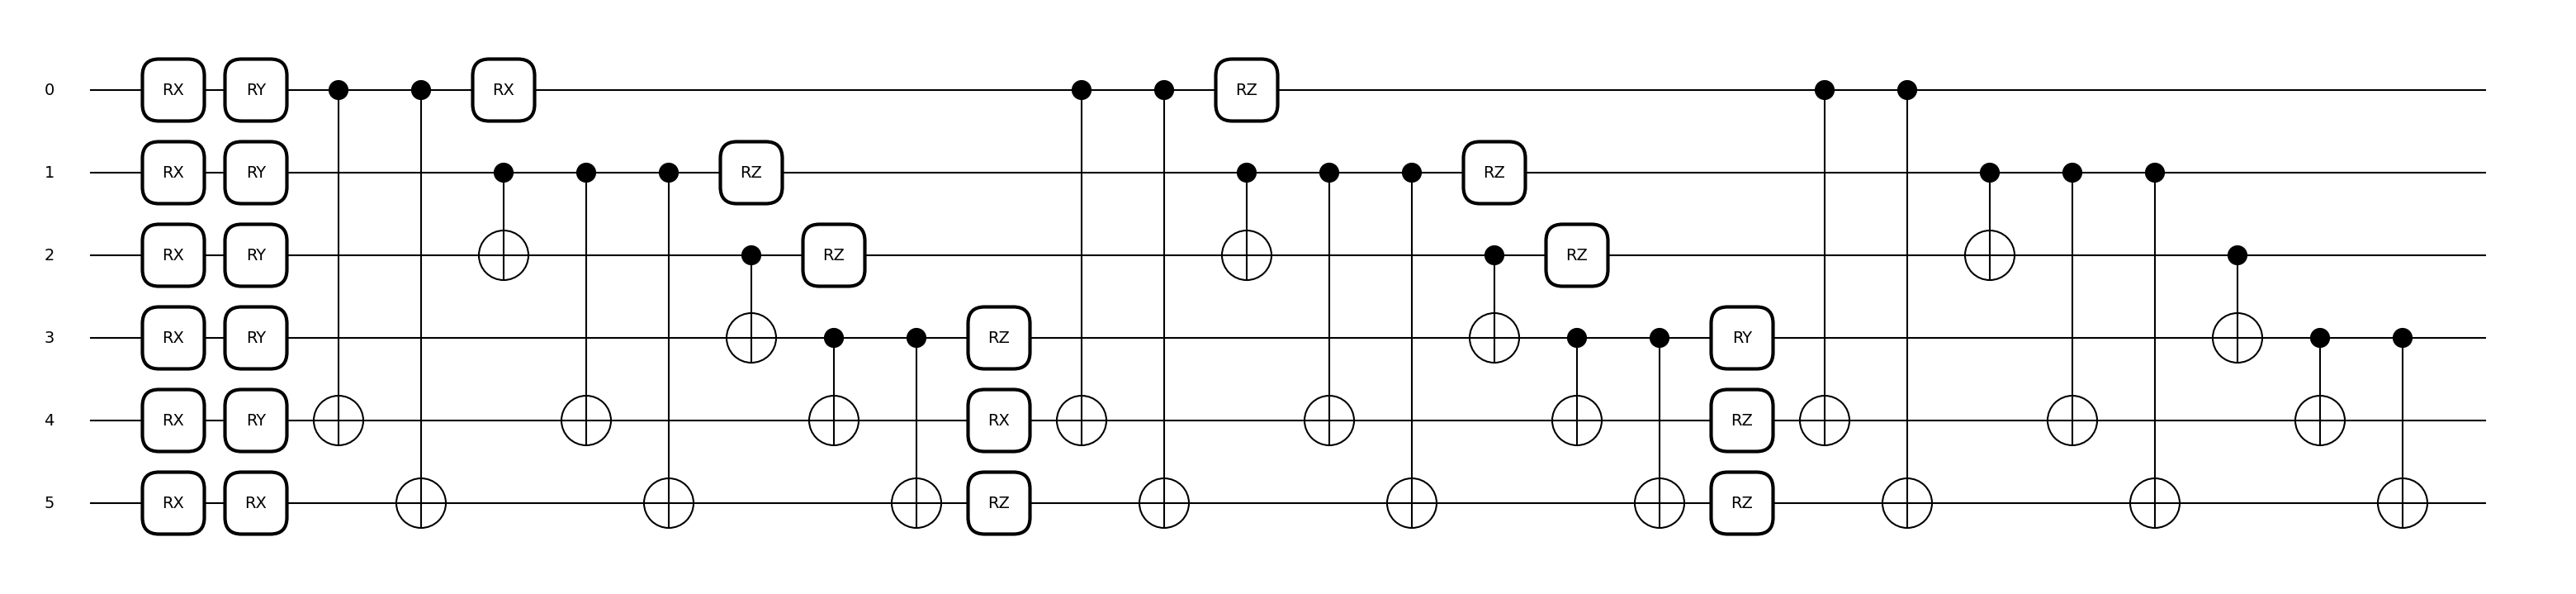

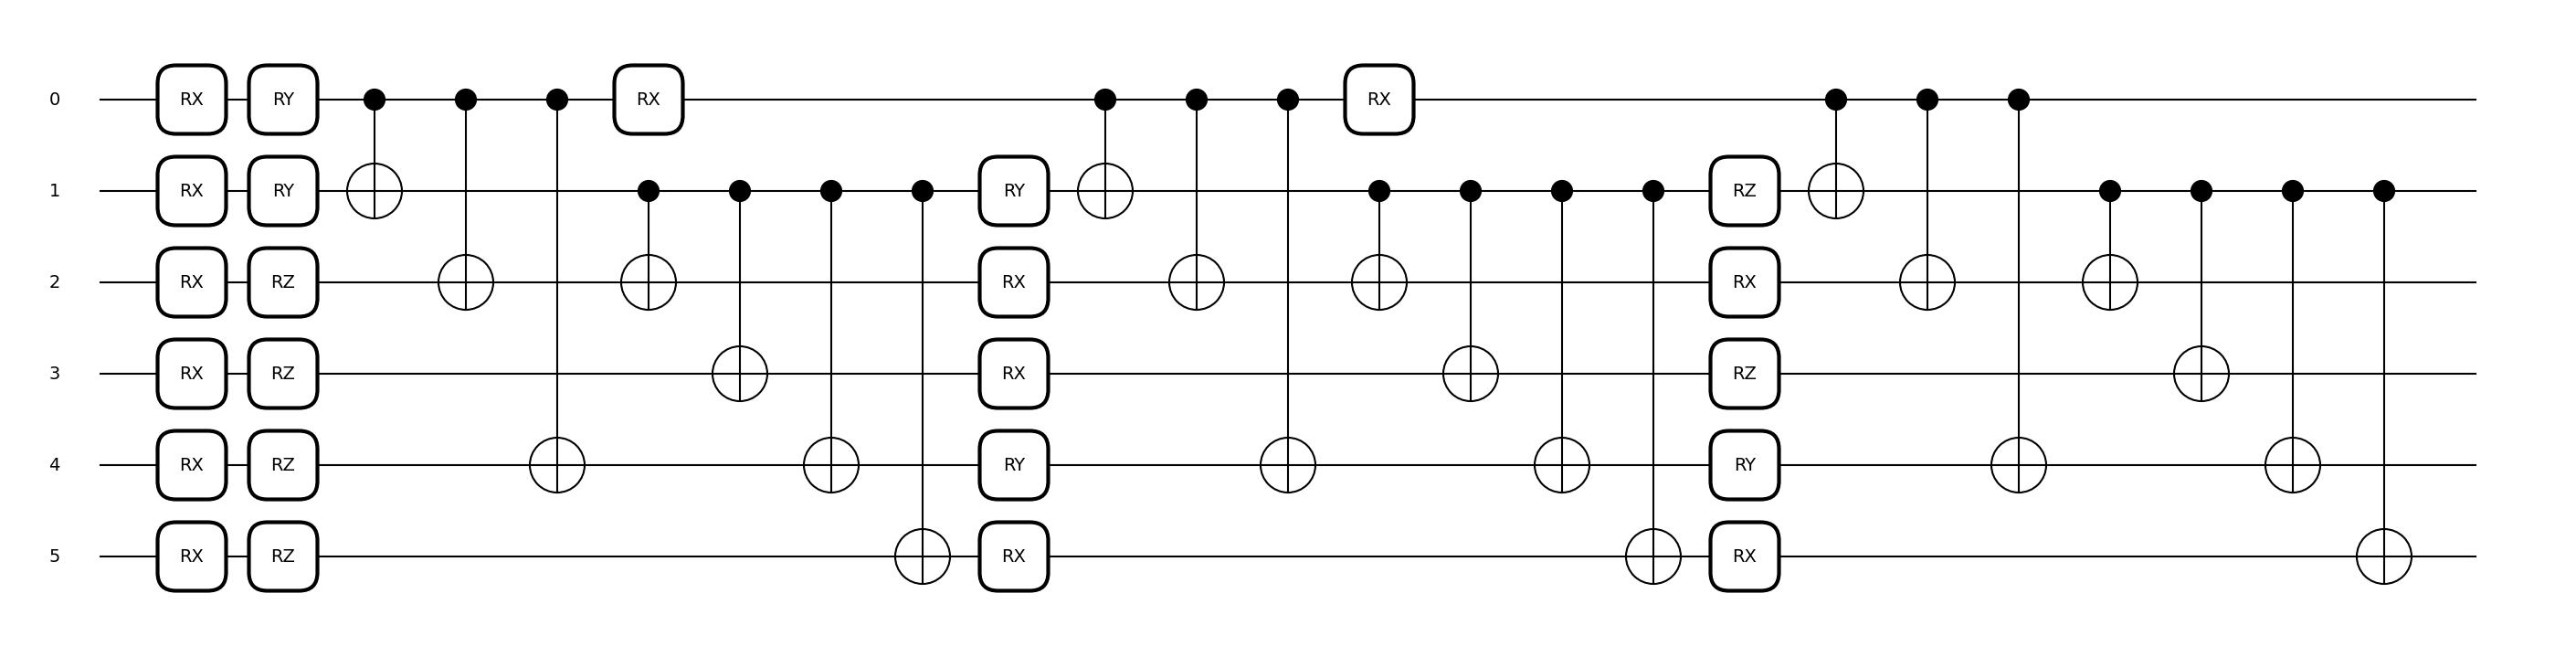

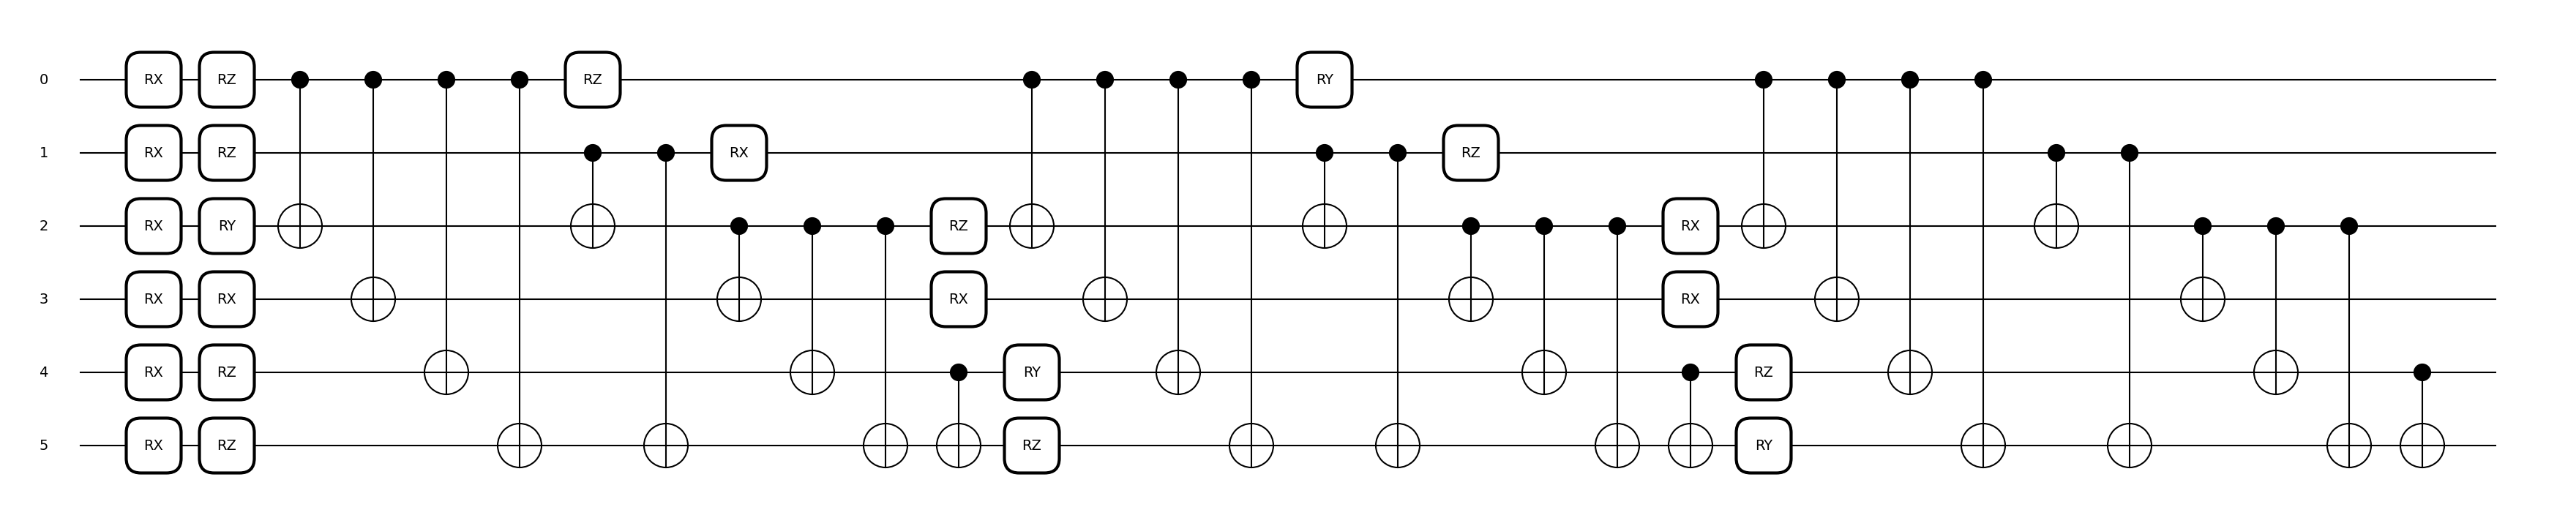

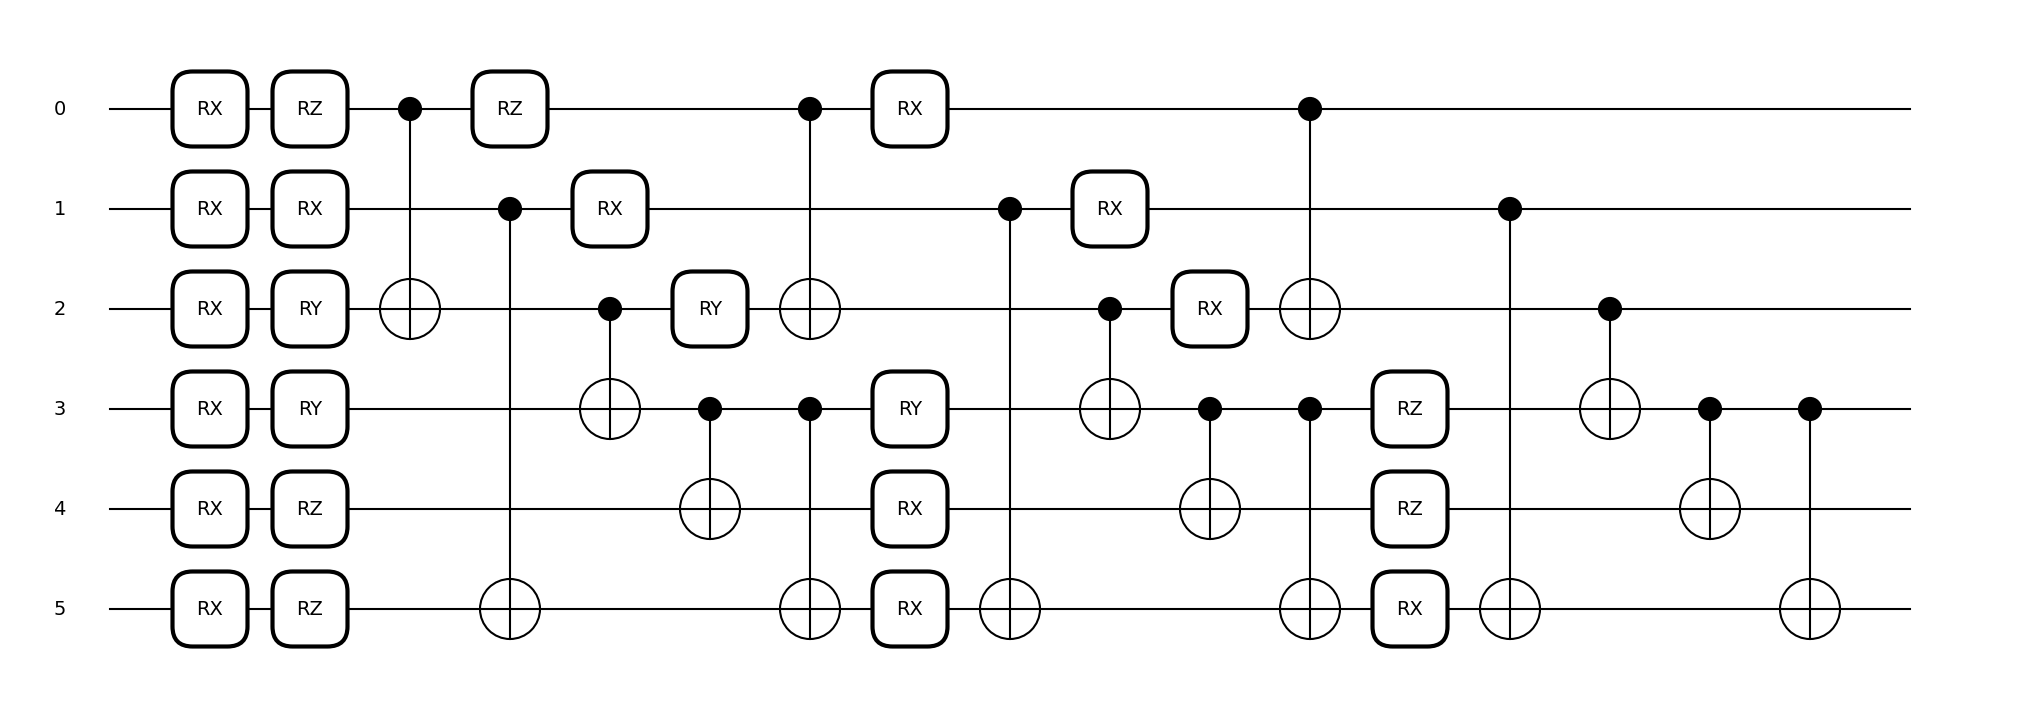

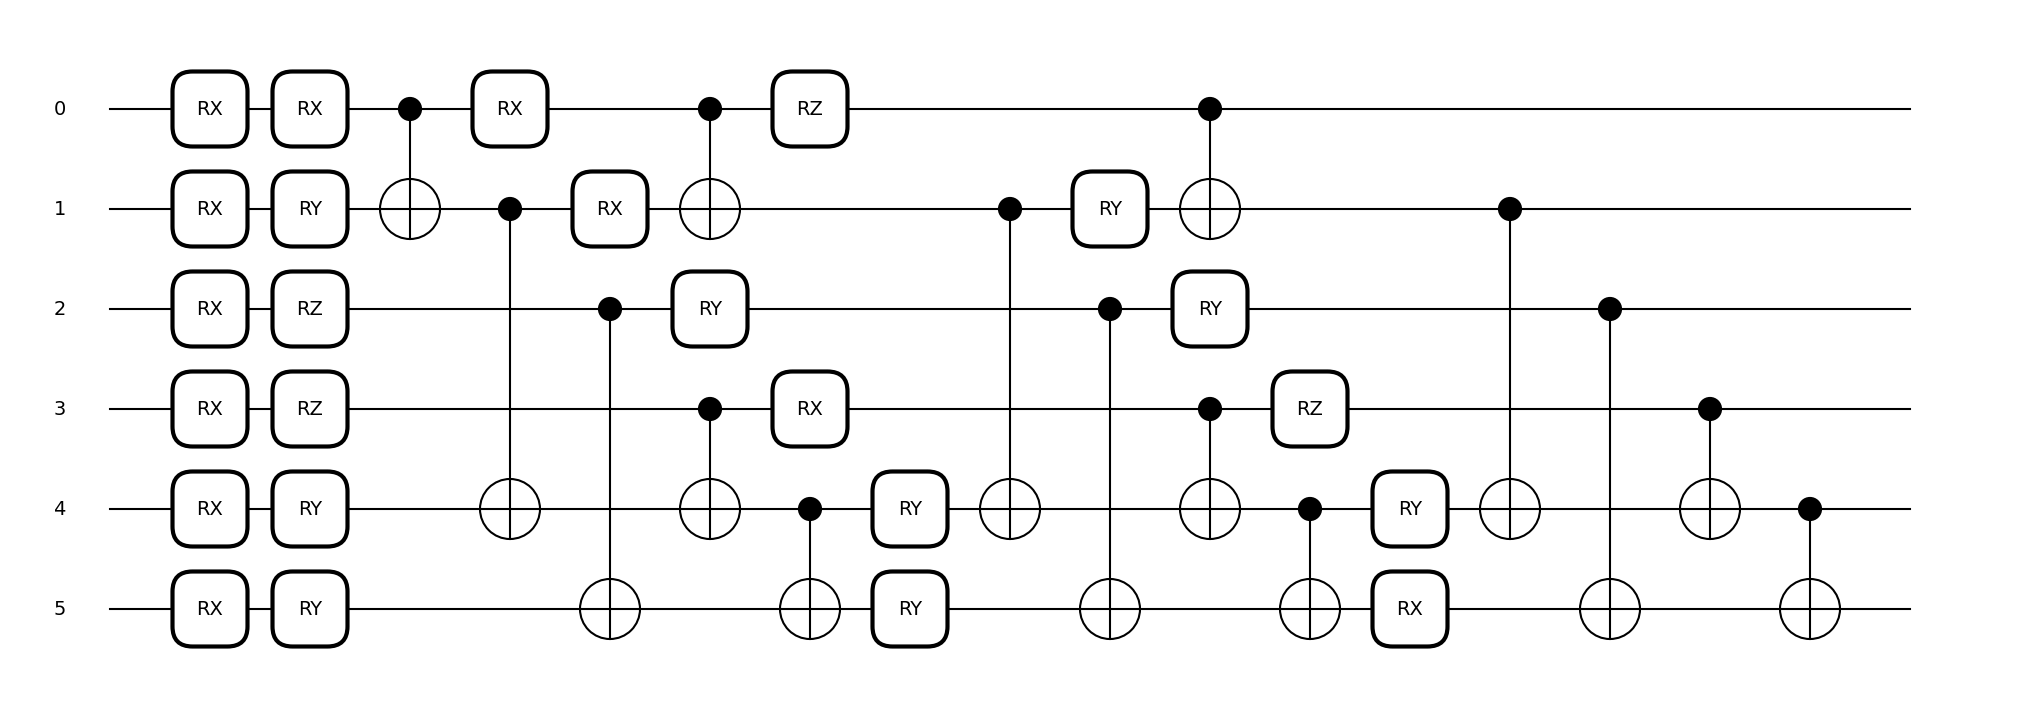

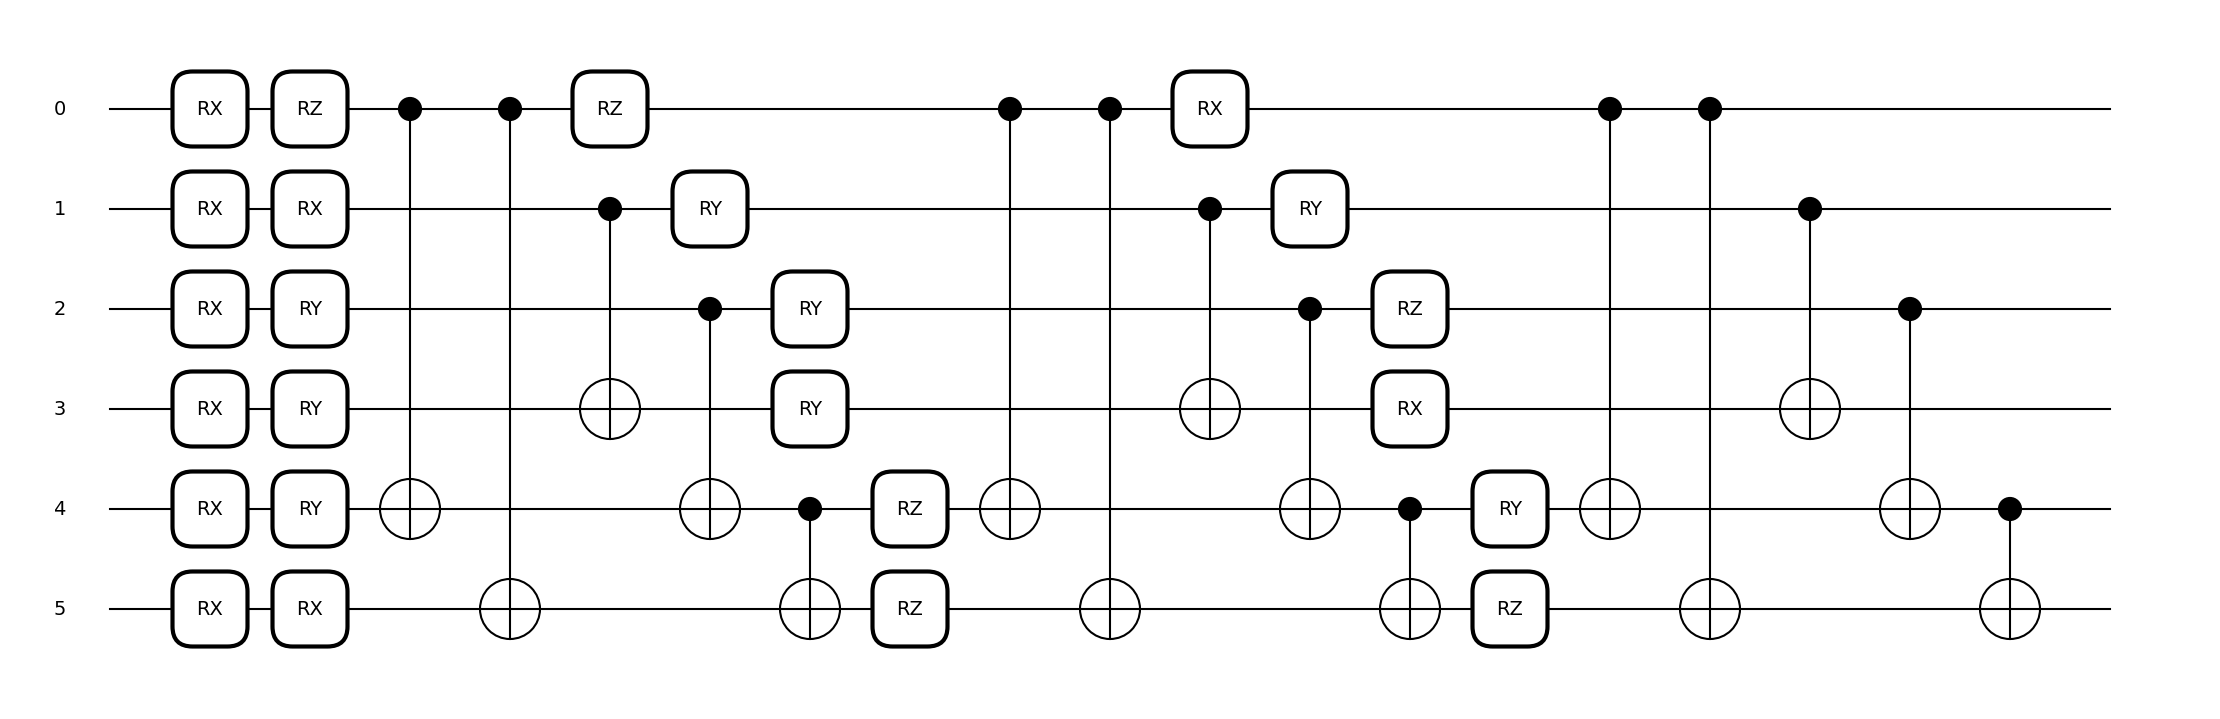

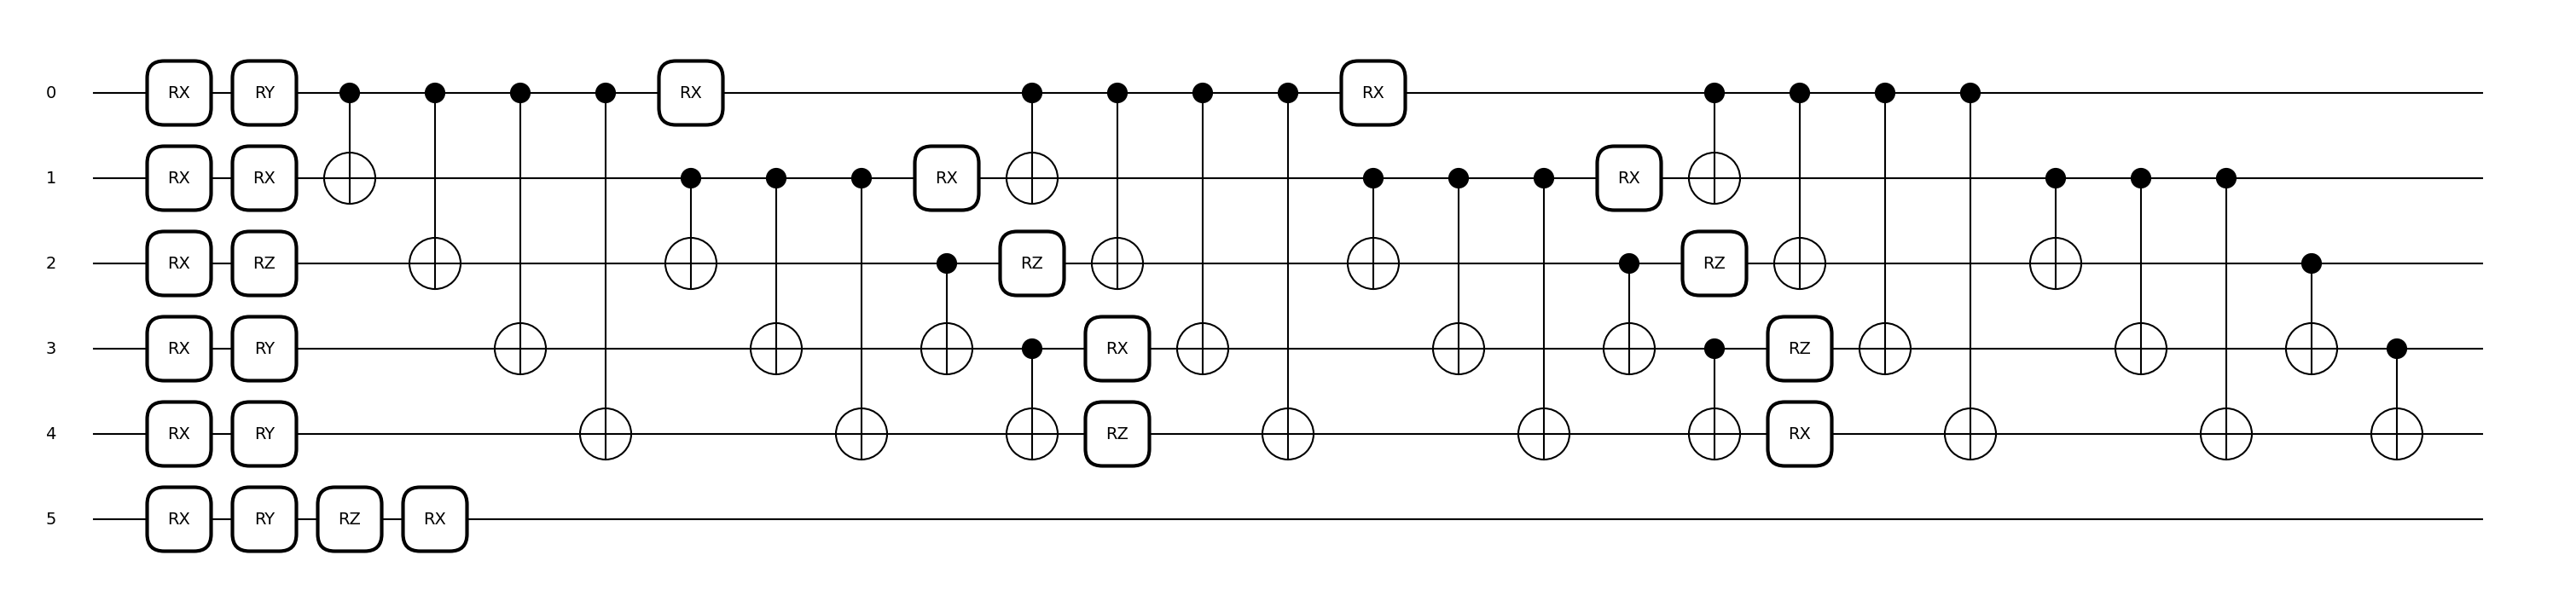

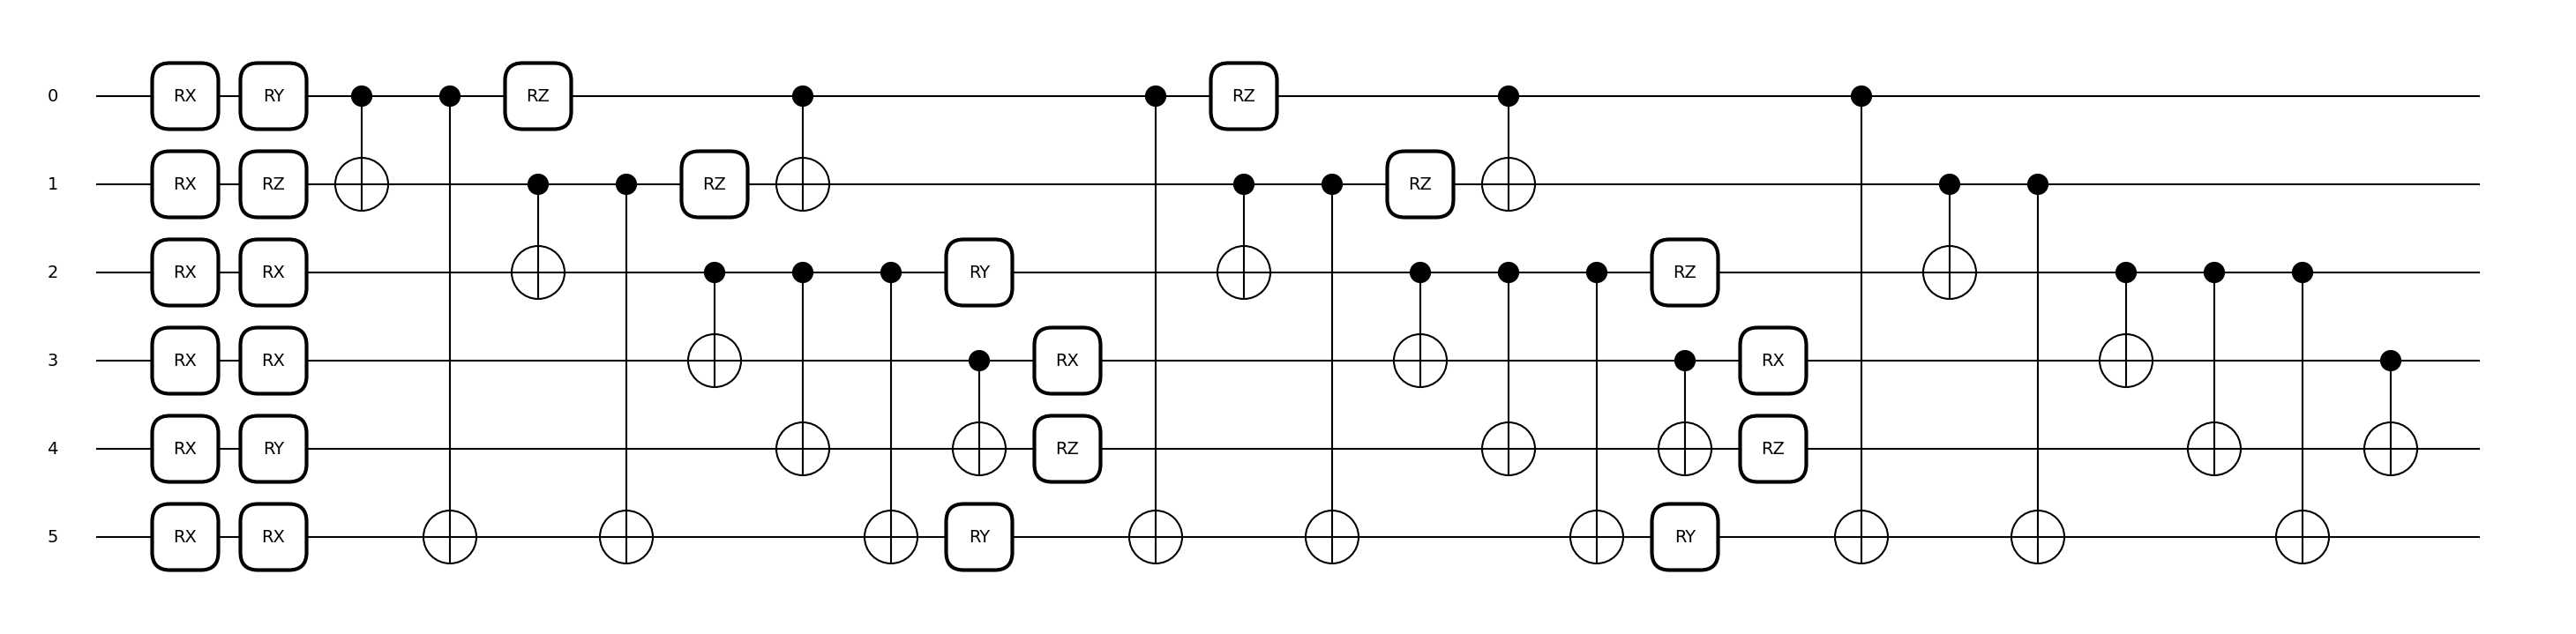

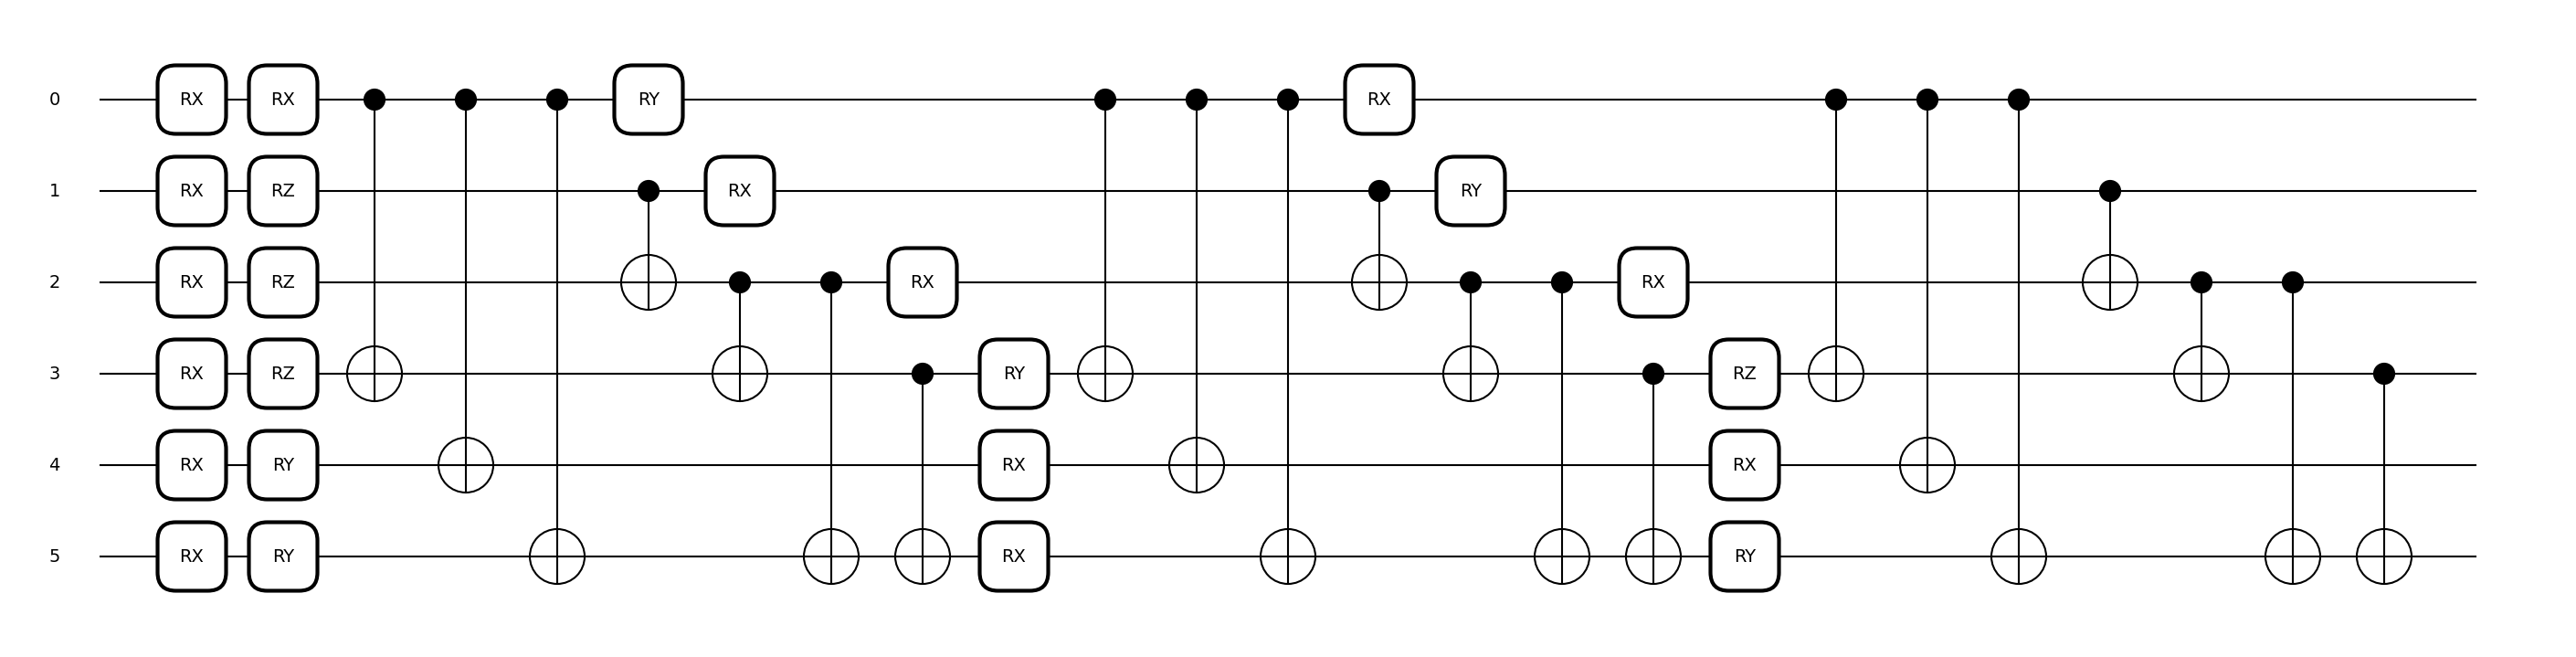

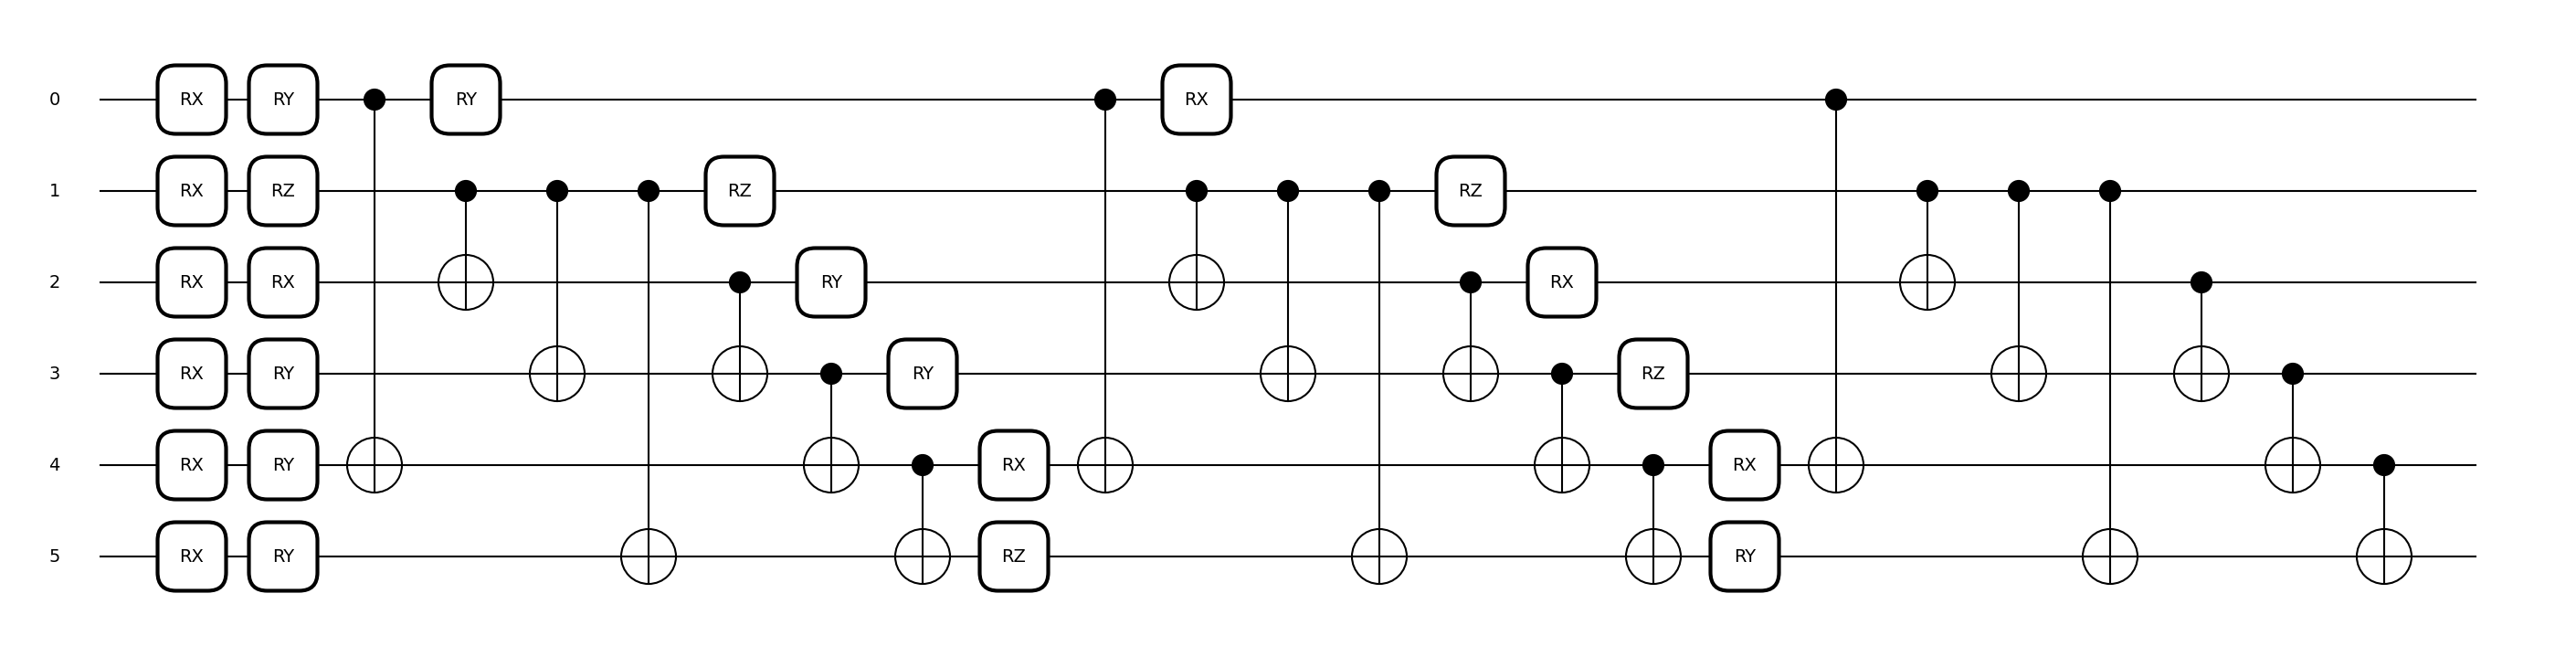

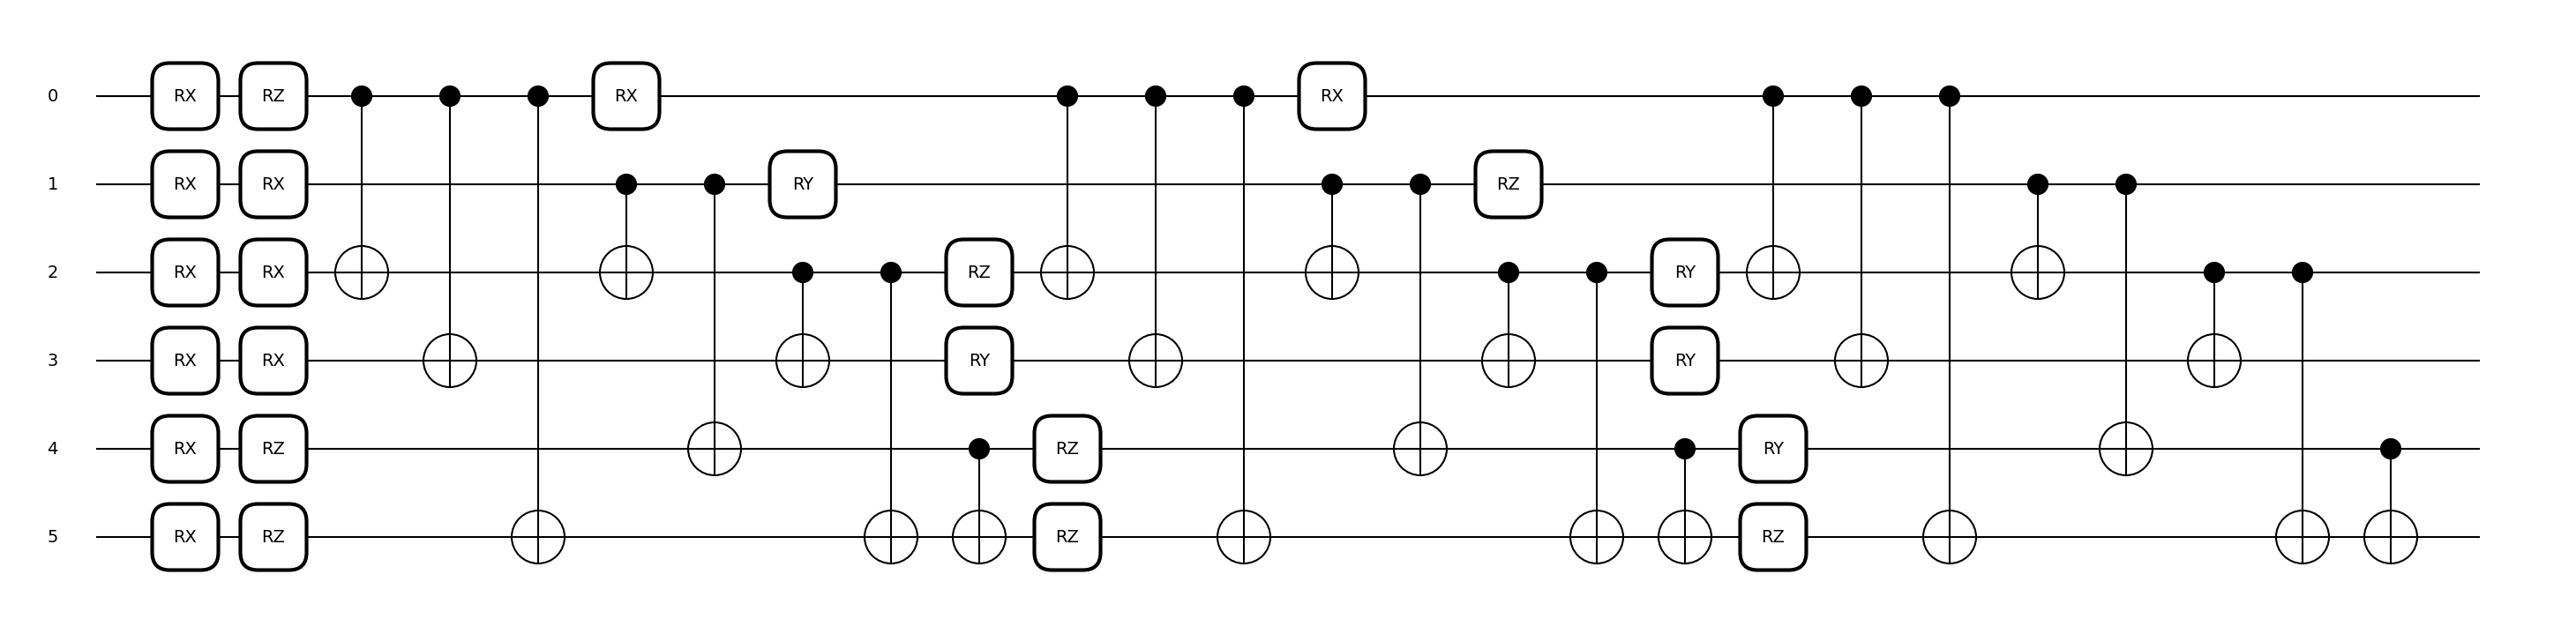

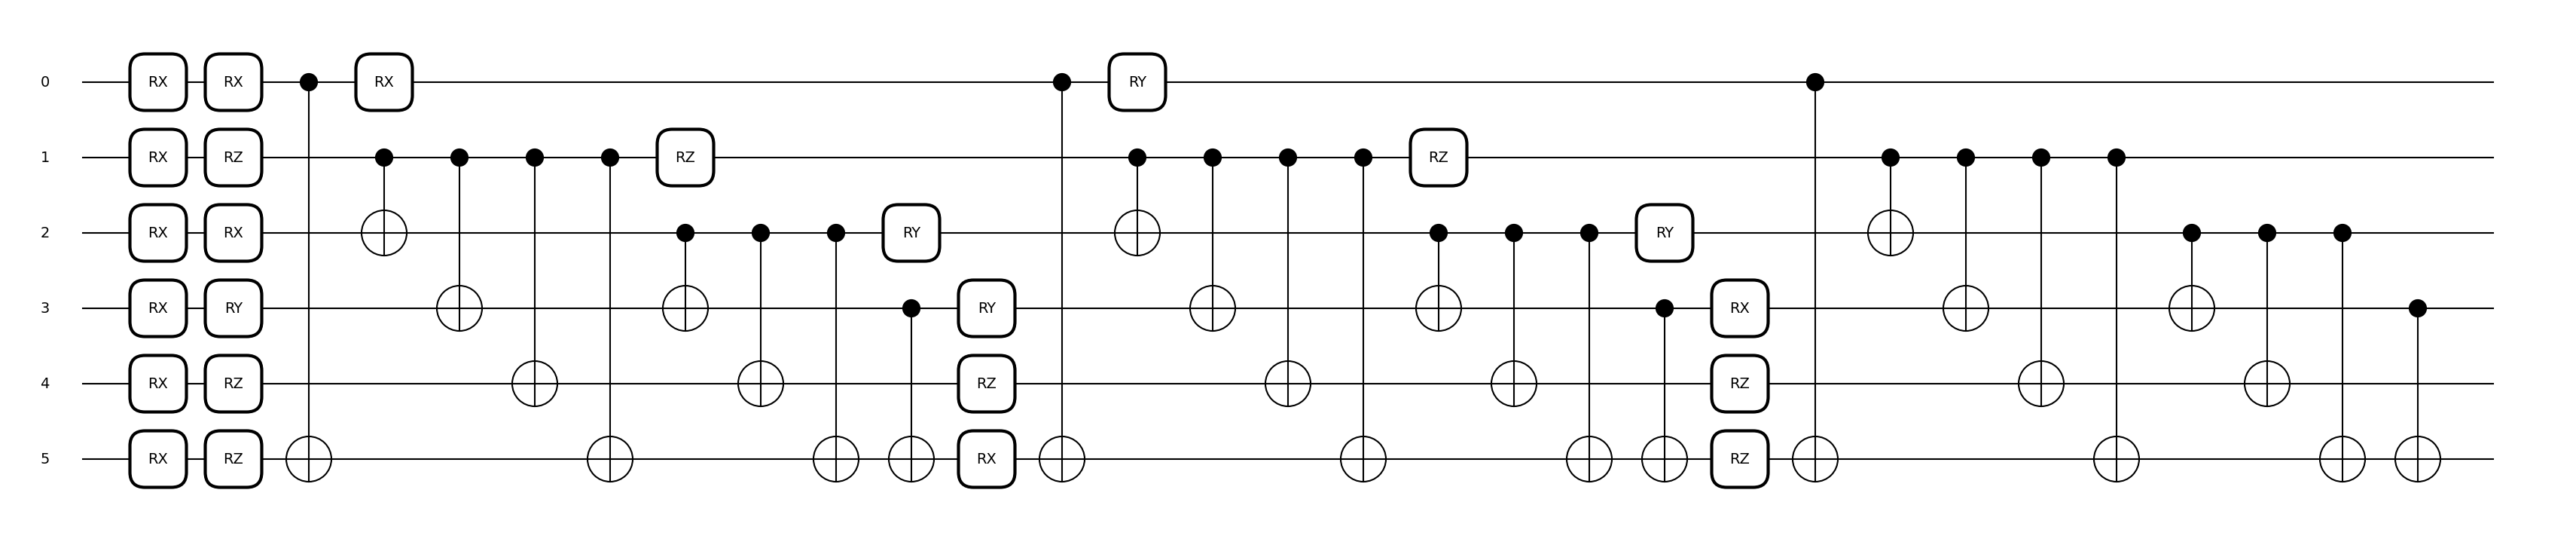

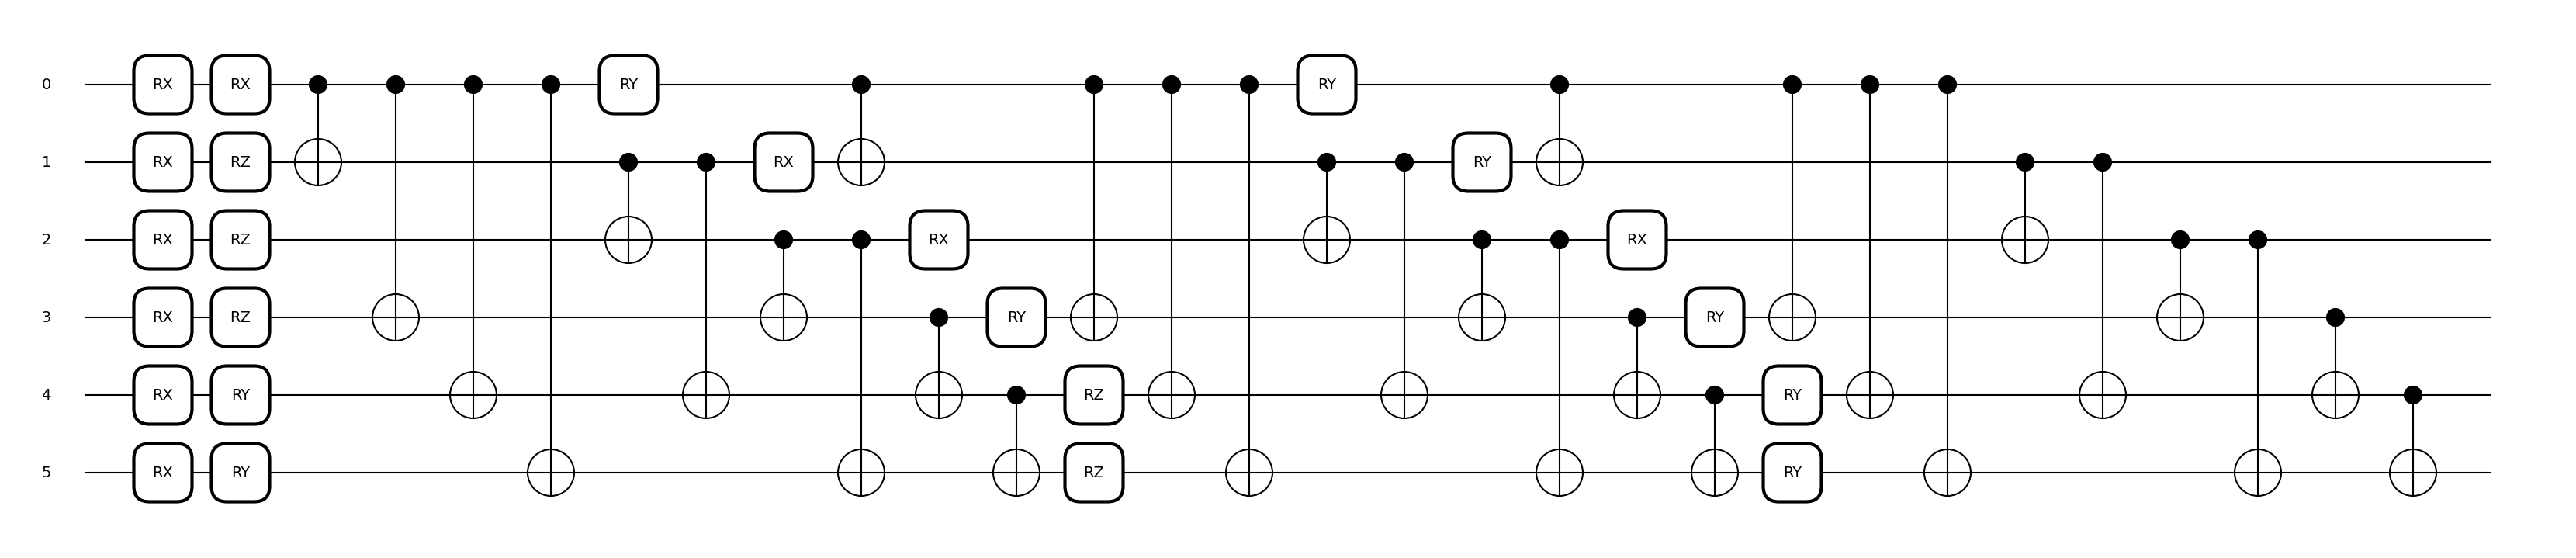

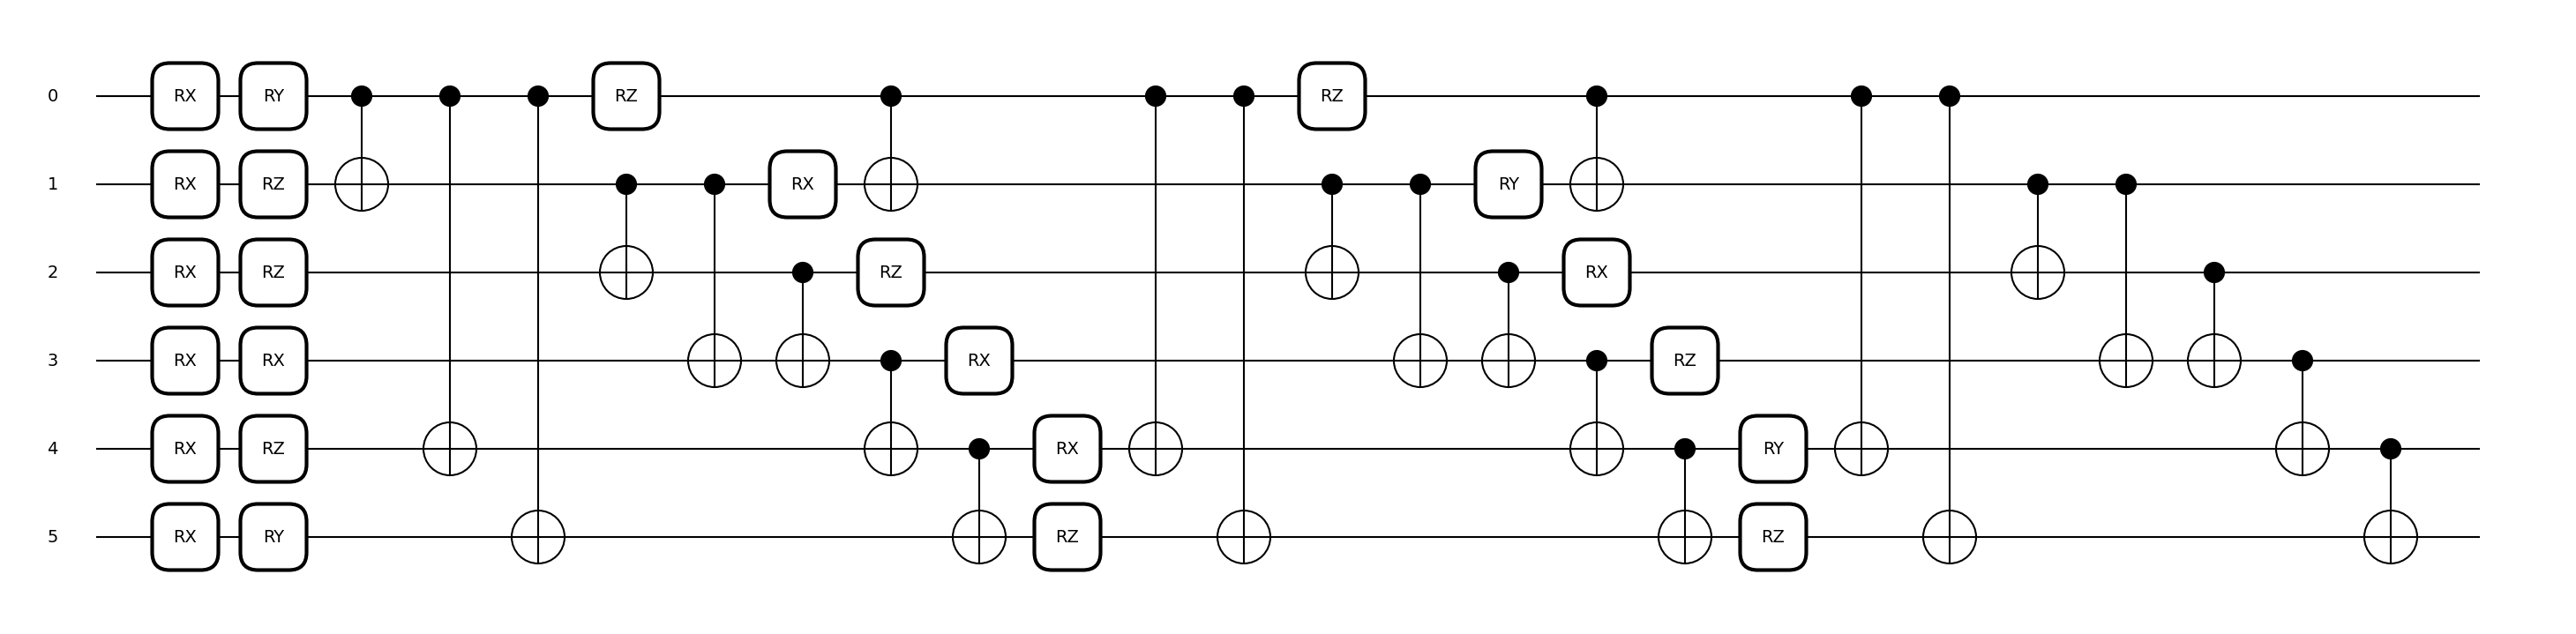

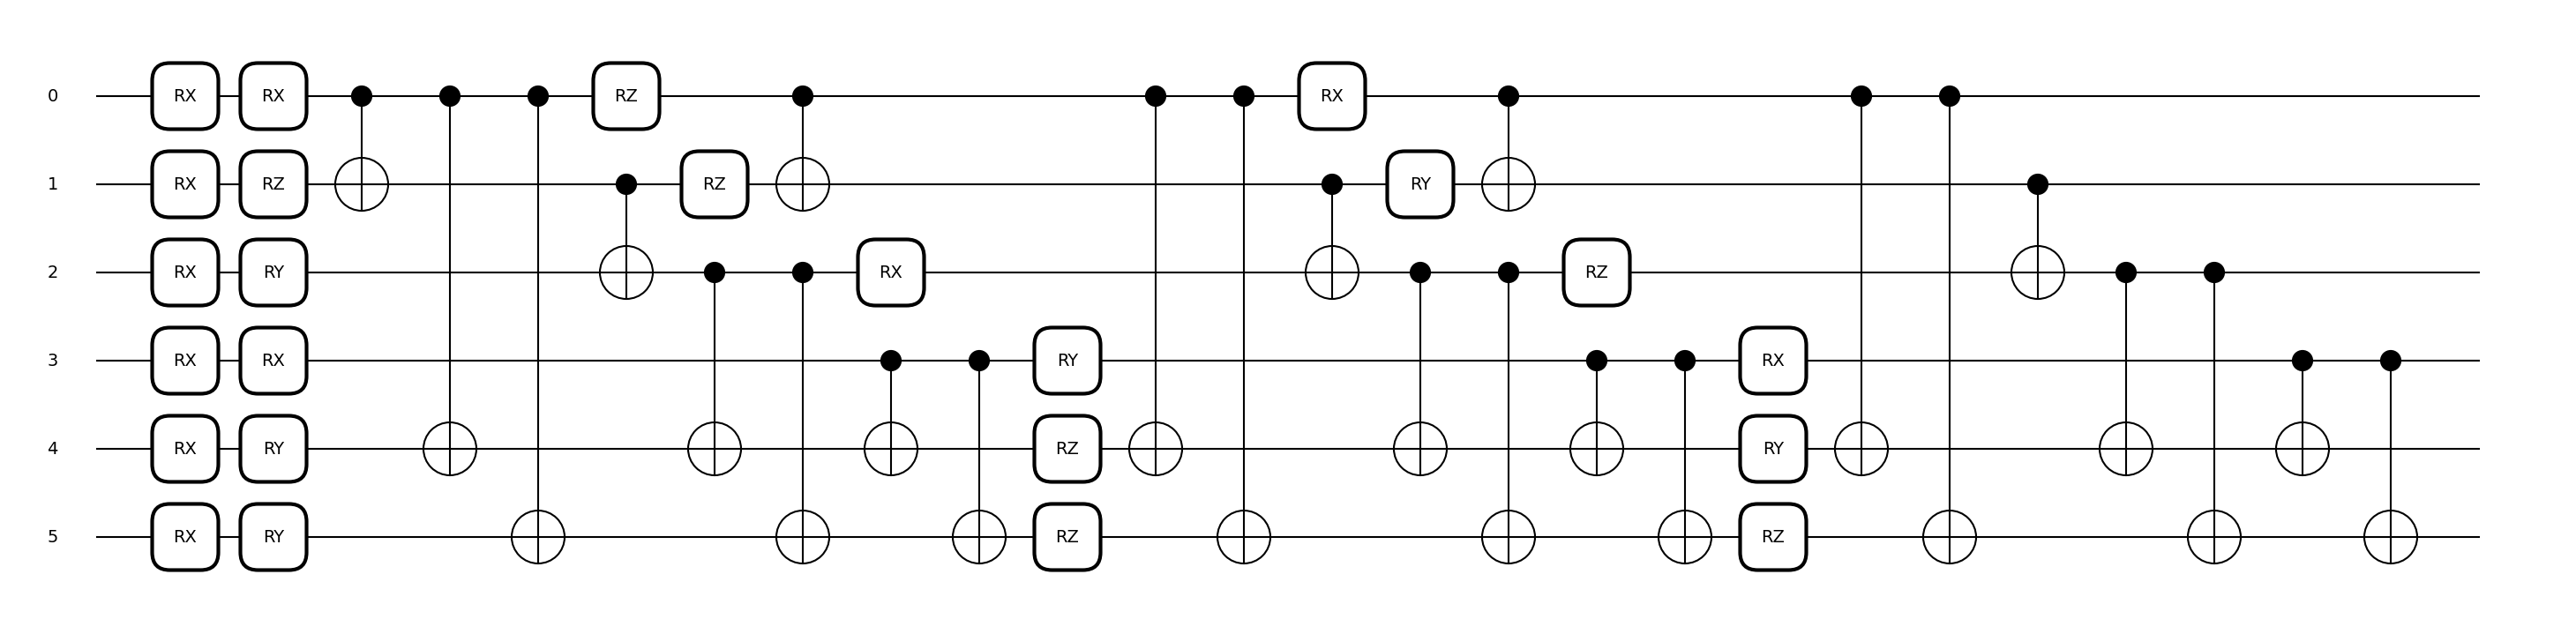

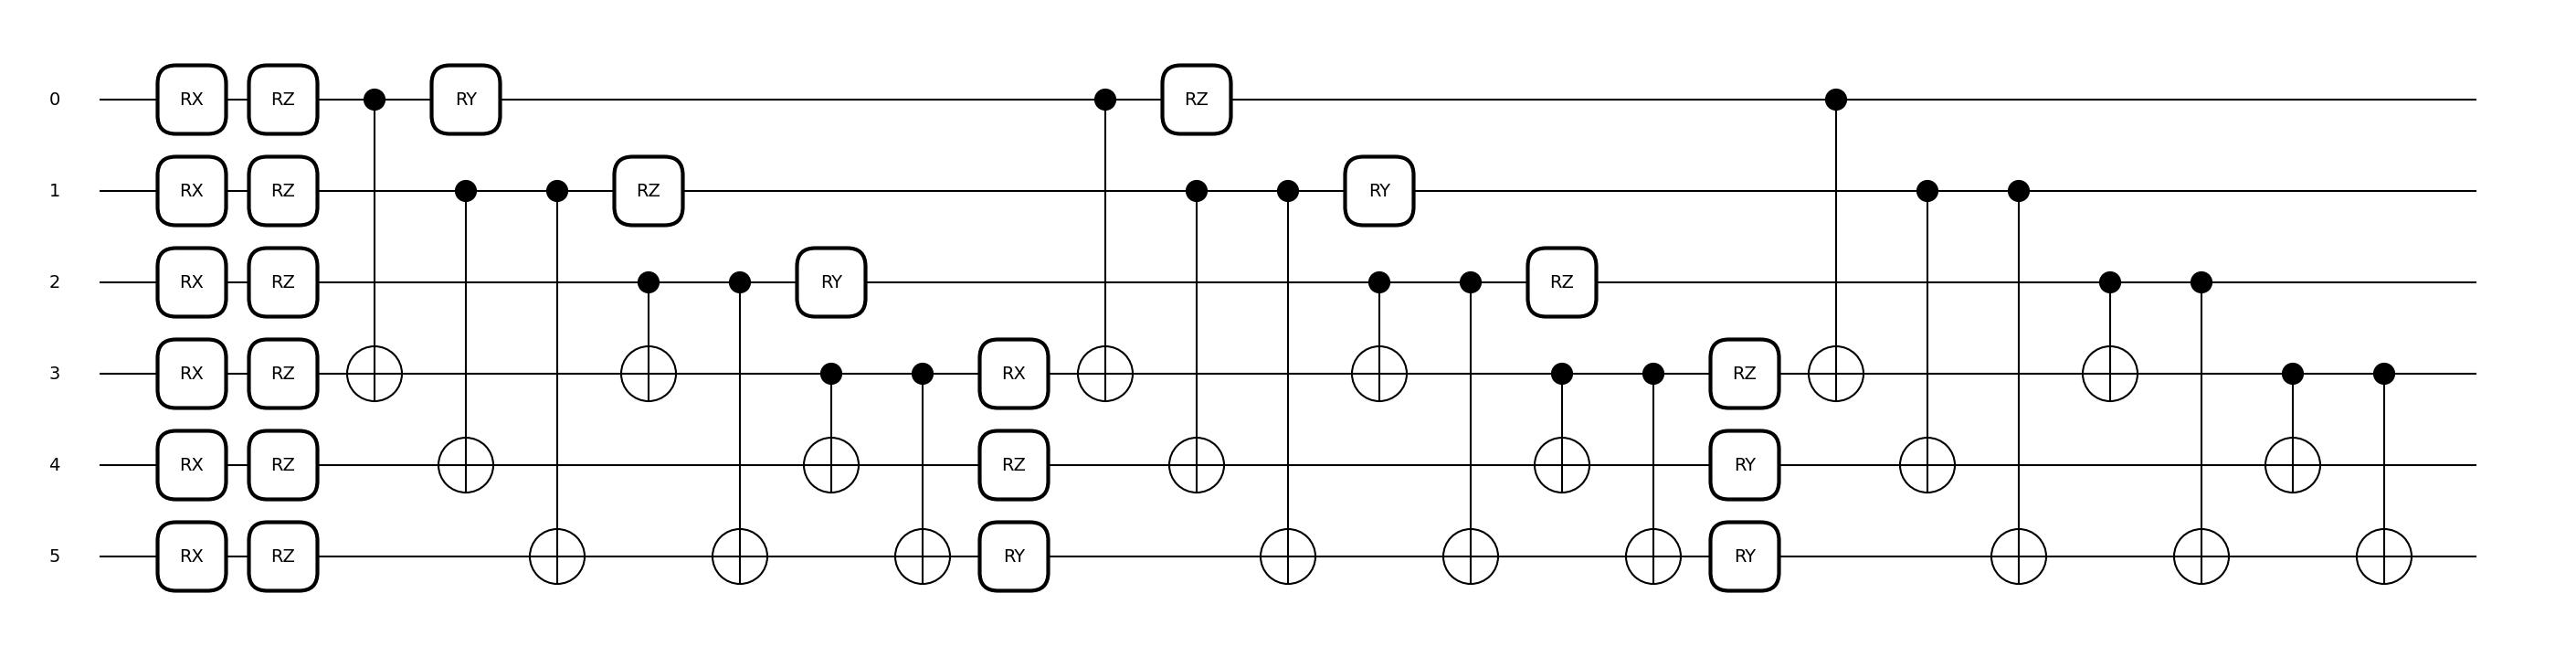

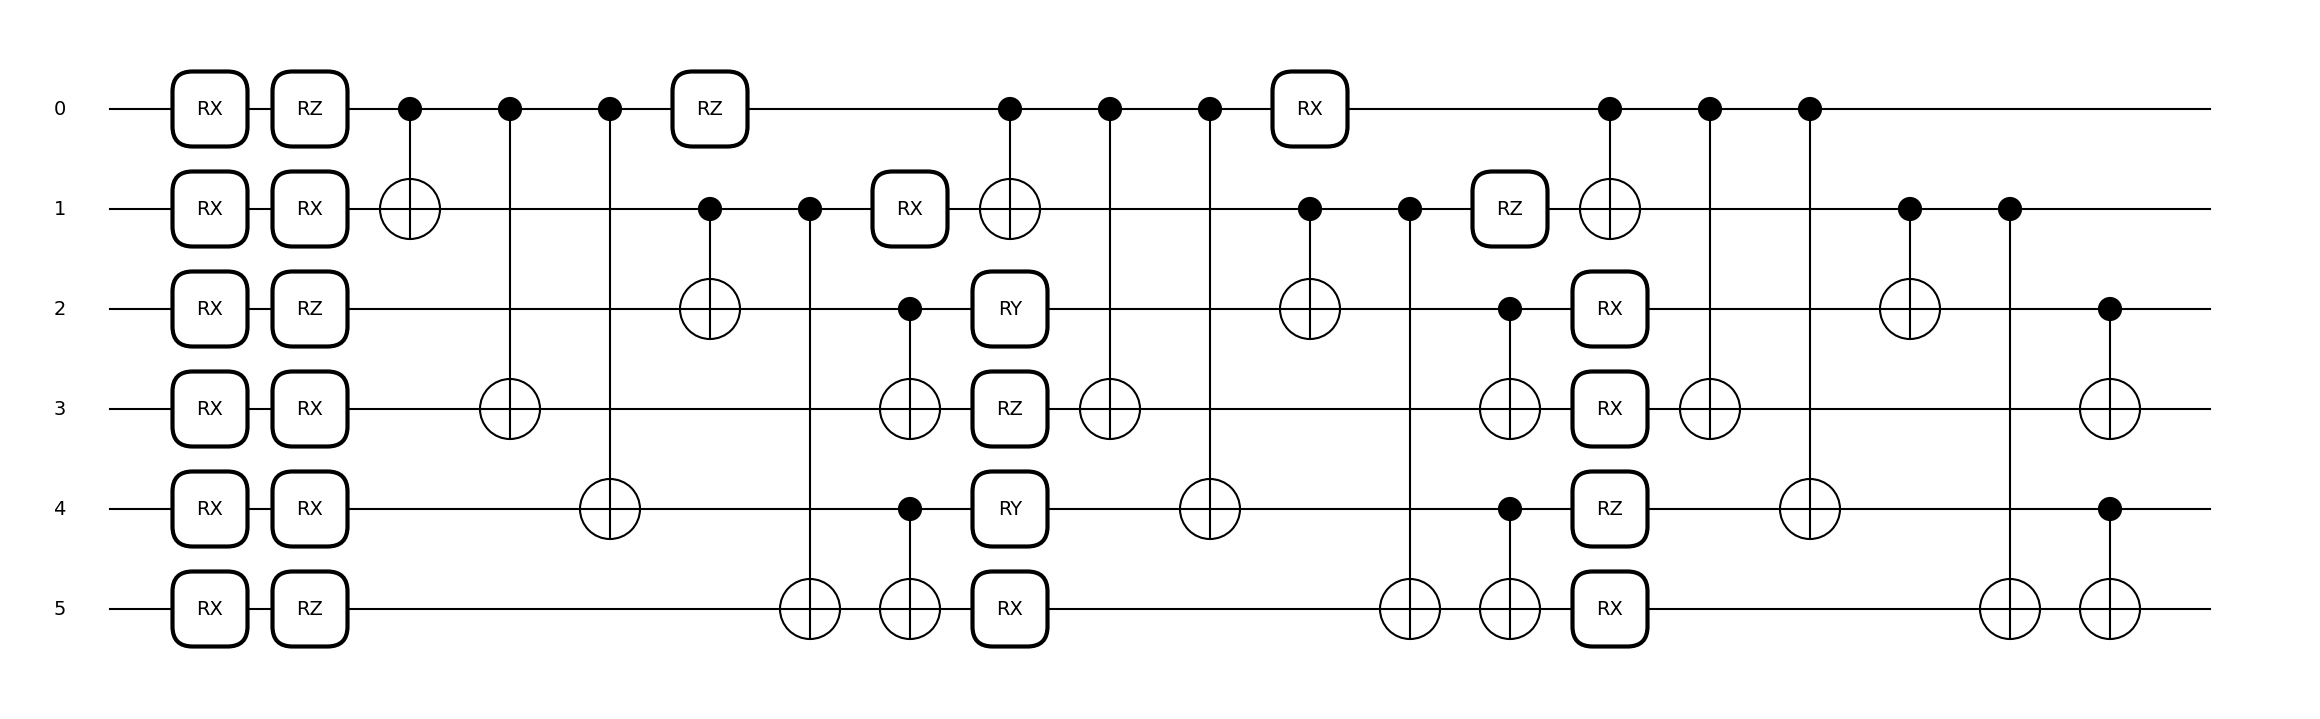

In [52]:
c.draw_diagram()

/Users/hyrelfyseaq493/anaconda3/lib/python3.10/site-packages/pennylane/drawer/draw.py:536: UserWarning: When the input to qml.draw is not a QNode, the expansion_strategy argument is ignored.
  warnings.warn(


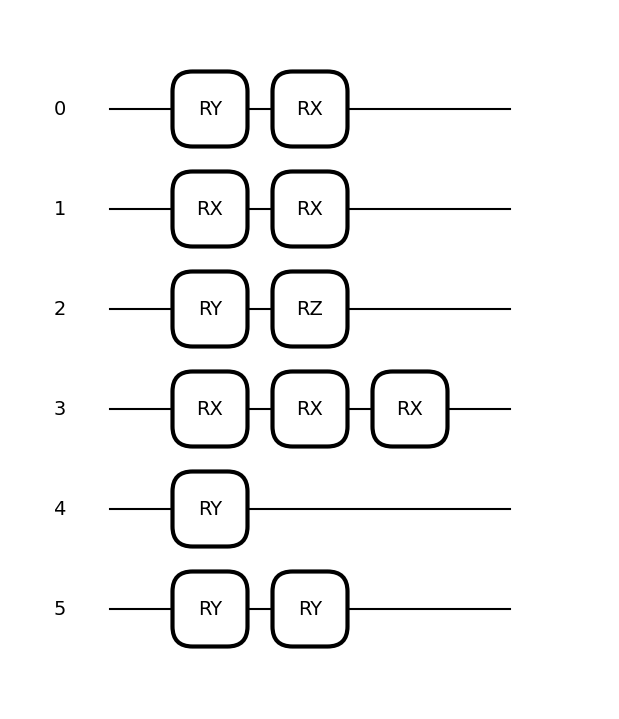

In [3]:
def func():
    op_list = []
    op_list.append(qml.RY(0, wires=0))
    op_list.append(qml.RX(0, wires=0))
    op_list.append(qml.RX(0, wires=1))
    op_list.append(qml.RX(0, wires=1))
    op_list.append(qml.RY(0, wires=2))
    op_list.append(qml.RZ(0, wires=2))
    op_list.append(qml.RX(0, wires=3))
    op_list.append(qml.RX(0, wires=3))#delete
    op_list.append(qml.RX(0, wires=3))
    op_list.append(qml.RY(0, wires=4))
    op_list.append(qml.RY(0, wires=5))#delete
    op_list.append(qml.RY(0, wires=5))
    return op_list
fig, ax = qml.draw_mpl(func, expansion_strategy="device")()

np.savetxt("comprehensive_performance_qa_bsm1.csv",c.popularity_ranking_qa(0,0,6))